In [1]:
%pylab inline
import openmc
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.colors import LogNorm
from PIL import Image
from uncertainties import ufloat, unumpy  #imprimir numeros con mas menos
import h5py                                 #para escribir archivos en formato .h5
import os
import kdsource as kds

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## MATERIALES

In [2]:
mat01 = openmc.Material(name='SS316L', material_id = 1)
mat01.add_nuclide("C0",0.001384, 'ao')
mat01.add_element("Si",0.019722, 'ao')
mat01.add_element("P", 0.000805, 'ao')
mat01.add_element("S", 0.000518, 'ao')
mat01.add_element("Cr",0.181098, 'ao')
mat01.add_element("Mn",0.020165 , 'ao')
mat01.add_element("Fe",0.648628, 'ao')
mat01.add_element("Ni",0.113247, 'ao')
mat01.add_element("Mo",0.014434, 'ao')
mat01.set_density('g/cm3', 8)

#concreto 91
Concreto = openmc.Material(name='Concreto', material_id = 2)
Concreto.add_element("H",0.086069, 'ao')
Concreto.add_nuclide('O16',0.314488*0.99757,'ao')
Concreto.add_nuclide('O17',0.314488*0.00243,'ao')
#Concreto.add_element('O',0.314488,'ao')
Concreto.add_element("Mg", 0.005516 , 'ao')
Concreto.add_element("Al", 0.014030 , 'ao')
Concreto.add_element("Si", 0.020499, 'ao')
Concreto.add_element("Ca", 0.050769, 'ao')
Concreto.add_element("Ti",0.012192 , 'ao')
Concreto.add_element("V", 0.000464, 'ao')
Concreto.add_element("Fe", 0.495972, 'ao')
Concreto.set_density('g/cm3',4.64)


poliboro = openmc.Material(name='Poliboro', material_id = 3)    #247
poliboro.add_element("H", 0.627759, 'ao')
poliboro.add_element("B", 0.046690 , 'ao')
poliboro.add_nuclide("C0", 0.325552 , 'ao')
poliboro.set_density('g/cm3',1)

Pb = openmc.Material(name='Plomo', material_id = 4)
Pb.add_element("Pb", 1, 'ao')
Pb.set_density('g/cm3',11.35)

H2O = openmc.Material(name="H2O", material_id=5)
H2O.add_nuclide('H1', 6.6765E-02)     #ao
H2O.add_nuclide('O16', 3.3338E-02)    #ao
H2O.add_s_alpha_beta('c_H_in_H2O')   #si no, simulo como gas libre, es molecula-> comportamiento macro de molecula
H2O.set_density('atom/b-cm',1.0001E-01)


Cd = openmc.Material(name="Cd", material_id=6)
Cd.add_element("Cd",1)                            #densidad de Cd
Cd.set_density('g/cm3',8.65)

#NO CREO QUE SEA ALUMINIO PURO, VER QUE ALEACION ES

Al = openmc.Material(name="Al", material_id=7)
Al.add_element("Al",1,'ao')                            #densidad de Cd
Al.set_density('g/cm3',2.6989)


#VER PROPORCIONES Y DENSIDADES
mat05 = openmc.Material(name="Zafiro", material_id=8)
mat05.add_element("Al",0.4,'ao')
mat05.add_nuclide('O16',0.6*0.99757,'ao')
mat05.add_nuclide('O17',0.6*0.00243,'ao')
#mat05.add_element("O",3/5,'ao')
mat05.add_s_alpha_beta('c_O_in_Sapphire')
mat05.add_s_alpha_beta('c_Al_in_Sapphire')
mat05.set_density('g/cm3', 3.98)


Aire = openmc.Material(name='Aire', material_id = 9)
Aire.add_nuclide("C0", 0.000150, 'ao')
Aire.add_element("N", 0.784431 , 'ao')
Aire.add_nuclide('O16',0.210748*0.99757,'ao')
Aire.add_nuclide('O17',0.210748*0.00243,'ao')
#Aire.add_element("O", 0.210748 , 'ao')
Aire.add_element("Ar",0.004671 , 'ao')
Aire.set_density('g/cm3',0.001205)

#goma de litio
Goma_litio = openmc.Material(name='Goma de Litio', material_id = 10)
Goma_litio.add_nuclide("C0", 0.969418768266905, 'wo')
Goma_litio.add_nuclide("Li6",0.005504621711957, 'ao')
Goma_litio.add_nuclide("Li7", 0.025076610021138, 'ao')
Goma_litio.set_density('g/cm3',1725)



#Creo recordar que era un polimero (CH2) con LiF, y litio enriquecido al 30%a en Li6.
#Para una mezcla aproximada de 40% en peso con el polimero,
#se obtiene algo que atenúa un haz termico aprox. 45 %.
# PEDIR DENSIDAD

## GEOMETRIA

## UNIVERSO 2 - CAMARA INTERNA

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

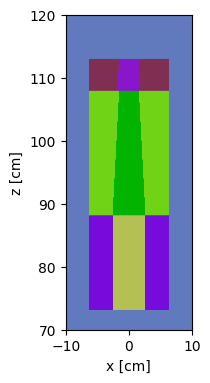

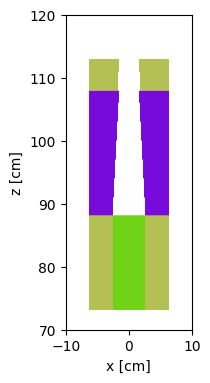

In [3]:
z_100=73.2
z_101=z_100+15
z_102=z_101+19.8
z_103=z_102+5
z_104=z_103+0.1               #supongo 0.1cm el espesor del Cd
inicio_cono_1=64.7143+z_100
inicio_cono_2=inicio_cono_1+4.857143
R_camara=6.41
R_zafiro=2.5
R_Pb_1=2.61
R_Pb_2=1.56
R_Cd=1.55


#Cilindro camara
cil_camara= openmc.ZCylinder(r=R_camara,y0=0,x0=0,surface_id=101, name="cil_1")
#Cilindro Zafiro
cil_zafiro= openmc.ZCylinder(r=R_zafiro,y0=0,x0=0,surface_id=102, name="cil_2")
#Cono Pb
exp_Pb=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_1, r2=0.00275, surface_id=103, name="exp_Pb")
#Cono Poliboro
exp_Poli=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_2, r2=0.00275, surface_id=104, name="exp_poli")
#planos de corte
planoZ_100=openmc.ZPlane(z0=z_100,surface_id=105, name="plano_1")
planoZ_101=openmc.ZPlane(z0=z_101,surface_id=106, name="plano_2")
planoZ_102=openmc.ZPlane(z0=z_102,surface_id=107, name="plano_2")
planoZ_103=openmc.ZPlane(z0=z_103,surface_id=108, name="plano_3")
planoZ_104=openmc.ZPlane(z0=z_104,surface_id=109, name="plano_4")
#cilindro Cd
cil_Cd= openmc.ZCylinder(r=R_Cd,y0=0,x0=0,surface_id=110, name="cil_2")


#defino las regiones
Cil_zafiro = (-cil_zafiro & +planoZ_100 & -planoZ_101)#1
cil_Poliboro_1 = (+cil_zafiro & -cil_camara & +planoZ_100 & -planoZ_101) #2
cono_haz_1 = (-exp_Pb & +planoZ_101 & -planoZ_102) #3
cil_Pb = (+exp_Pb & -cil_camara & +planoZ_101 & -planoZ_102) #4
cono_haz_2 = (-exp_Poli & +planoZ_102 & -planoZ_103) #5
cono_poli = (+exp_Poli & -cil_camara & +planoZ_102 & -planoZ_103)#6
cil_Cd = (+cil_Cd & -cil_camara & +planoZ_103 & -planoZ_104)#7
out_CI = ~(Cil_zafiro|cil_Poliboro_1 |cono_haz_1 |cono_haz_2 |cil_Pb| cil_Cd|cono_poli)


#defino celdas
cell_zafiro = openmc.Cell(region = Cil_zafiro , fill = mat05  , cell_id = 101)
cell_poliboro_1 = openmc.Cell(region = cil_Poliboro_1, fill = poliboro , cell_id = 102)
cell_cono_haz = openmc.Cell(region = cono_haz_1, fill = None , cell_id = 103)
cell_Pb = openmc.Cell(region =cil_Pb , fill = Pb  , cell_id = 104)
cell_cil_haz = openmc.Cell(region = cono_haz_2, fill = None , cell_id = 105)
cell_poliboro_2 = openmc.Cell(region = cono_poli , fill = poliboro  , cell_id = 106)
cell_Cd = openmc.Cell(region =cil_Cd, fill = Cd  , cell_id = 107)
cell_out_CI = openmc.Cell(region =out_CI, fill = None  , cell_id = 108)

univ02 = openmc.Universe(cells = [cell_out_CI ,cell_zafiro,cell_poliboro_1,cell_cono_haz ,cell_Pb,cell_cil_haz ,cell_poliboro_2,cell_Cd], universe_id = 2)

univ02.plot(width =  (20,50),origin= (0,0,95), basis='xz')
univ02.plot(width = (20,50),origin= (0,0,95), basis='xz',color_by='material')

## UNIVERSO 4 - CAMARA EXTERNA

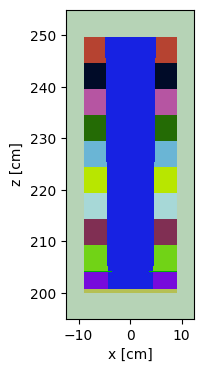

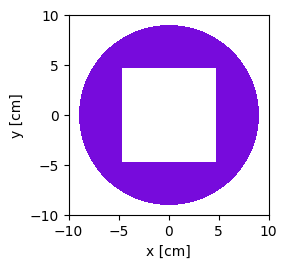

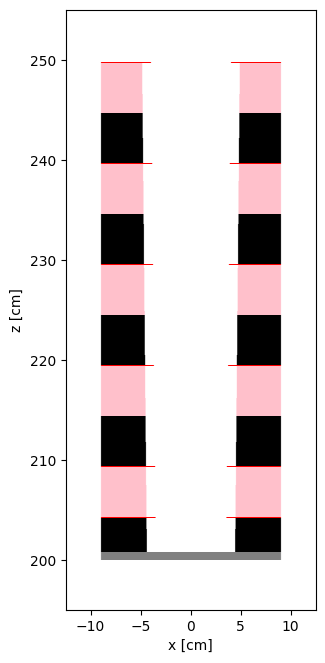

In [4]:
e_Cd=0.1
z_300=200
z_301=z_300+0.8
z_302=z_301+3.4
z_303=z_302+0.1
z_304=z_303+5.0
z_305=z_304+0.1
z_306=z_305+5.0
z_307=z_306+5.0
z_308=z_307+0.1
z_309=z_308+5.0
z_310=z_309+5.0
z_311=z_310+0.1
z_312=z_311+5.0
z_313=z_312+5.0
z_314=z_313+0.1
z_315=z_314+5.0
z_316=z_315+5.0
z_317=z_316+0.1
R_camara_CE=9

#planos poliboro+Pb
Cono_P_1=openmc.Plane.from_points(p1=(0,0,-459.487234+200),p2=(4.4476,4.4476,4.2+200),p3=(4.4476,-4.4476,4.2+200), surface_id=300, name="cono_P_1")
Cono_P_2=openmc.Plane.from_points(p1=(0,0,-459.487234+200),p2=(-4.4476,4.4476,4.2+200),p3=(-4.4476,-4.4476,4.2+200), surface_id=301, name="cono_P_2")
Cono_P_3=openmc.Plane.from_points(p1=(0,0,-459.487234+200),p2=(4.4476,-4.4476,4.2+200),p3=(-4.4476,-4.4476,4.2+200), surface_id=302, name="cono_P_3")
Cono_P_4=openmc.Plane.from_points(p1=(0,0,-459.487234+200),p2=(-4.4476,4.4476,4.2+200),p3=(4.4476,4.4476,4.2+200), surface_id=303, name="cono_P_4")

#planos Cd
Cono_Cd_1=openmc.Plane.from_points(p1=(0,0,-365.553131+200),p2=(3.54853,3.54853,4.2+200),p3=(3.54853,-3.54853,4.2+200), surface_id=304, name="cono_P_1")
Cono_Cd_2=openmc.Plane.from_points(p1=(0,0,-365.553131+200),p2=(-3.54853,3.54853,4.2+200),p3=(-3.54853,-3.54853,4.2+200), surface_id=305, name="cono_P_2")
Cono_Cd_3=openmc.Plane.from_points(p1=(0,0,-365.553131+200),p2=(3.54853,-3.54853,4.2+200),p3=(-3.54853,-3.54853,4.2+200), surface_id=306, name="cono_P_3")
Cono_Cd_4=openmc.Plane.from_points(p1=(0,0,-365.553131+200),p2=(-3.54853,3.54853,4.2+200),p3=(3.54853,3.54853,4.2+200), surface_id=307, name="cono_P_4")



#surf001=openmc.surface.Plane.from_points(p1,p2,p3) FALTA

#Cilindro camara
cil_camara= openmc.ZCylinder(r=R_camara_CE,y0=0,x0=0,surface_id=326, name="cil_1")
#Cono Pb
#exp_haz=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_CE, r2=0.000089, surface_id=302, name="exp_in")
#planos de corte
planoZ__0=openmc.ZPlane(z0=z_300,surface_id=308, name="plano_1")
planoZ__1=openmc.ZPlane(z0=z_301,surface_id=309, name="plano_2")
planoZ__2=openmc.ZPlane(z0=z_302,surface_id=310, name="plano_2")
planoZ__3=openmc.ZPlane(z0=z_303,surface_id=311, name="plano_3")
planoZ__4=openmc.ZPlane(z0=z_304,surface_id=312, name="plano_3")
planoZ__5=openmc.ZPlane(z0=z_305,surface_id=313, name="plano_3")
planoZ__6=openmc.ZPlane(z0=z_306,surface_id=314, name="plano_3")
planoZ__7=openmc.ZPlane(z0=z_307,surface_id=315, name="plano_3")
planoZ__8=openmc.ZPlane(z0=z_308,surface_id=316, name="plano_3")
planoZ__9=openmc.ZPlane(z0=z_309,surface_id=317, name="plano_3")
planoZ__10=openmc.ZPlane(z0=z_310,surface_id=318, name="plano_3")
planoZ__11=openmc.ZPlane(z0=z_311,surface_id=319, name="plano_3")
planoZ__12=openmc.ZPlane(z0=z_312,surface_id=320, name="plano_3")
planoZ__13=openmc.ZPlane(z0=z_313,surface_id=321, name="plano_3")
planoZ__14=openmc.ZPlane(z0=z_314,surface_id=322, name="plano_3")
planoZ__15=openmc.ZPlane(z0=z_315,surface_id=323, name="plano_3")
planoZ__16=openmc.ZPlane(z0=z_316,surface_id=324, name="plano_3")
planoZ__17=openmc.ZPlane(z0=z_317,surface_id=325, name="plano_3")

#defino las regiones

tapa= (-cil_camara & +planoZ__0 & -planoZ__1)
Pb_1_1= (-cil_camara & +Cono_P_1 & +planoZ__1 & -planoZ__2)
Pb_1_2= (-cil_camara & -Cono_P_2 & +planoZ__1 & -planoZ__2)
Pb_1_3= (-cil_camara & +Cono_P_3 & +planoZ__1 & -planoZ__2)
Pb_1_4= (-cil_camara & +Cono_P_4 & +planoZ__1 & -planoZ__2)
Pb_1 = (Pb_1_1 |Pb_1_2 | Pb_1_3| Pb_1_4 )
Cd_1_1= (-cil_camara & +Cono_Cd_1 & +planoZ__2 & -planoZ__3)
Cd_1_2= (-cil_camara & -Cono_Cd_2 & +planoZ__2 & -planoZ__3)
Cd_1_3= (-cil_camara & +Cono_Cd_3 & +planoZ__2 & -planoZ__3)
Cd_1_4= (-cil_camara & +Cono_Cd_4 & +planoZ__2 & -planoZ__3)
Cd_1 = (Cd_1_1 |Cd_1_2 | Cd_1_3| Cd_1_4 )
Poli_1_1= (-cil_camara & +Cono_P_1 & +planoZ__3 & -planoZ__4)
Poli_1_2= (-cil_camara & -Cono_P_2 & +planoZ__3 & -planoZ__4)
Poli_1_3= (-cil_camara & +Cono_P_3 & +planoZ__3 & -planoZ__4)
Poli_1_4= (-cil_camara & +Cono_P_4 & +planoZ__3 & -planoZ__4)
Poli_1 = (Poli_1_1 |Poli_1_2 | Poli_1_3| Poli_1_4 )
Cd_2_1= (-cil_camara & +Cono_Cd_1 & +planoZ__4 & -planoZ__5)
Cd_2_2= (-cil_camara & -Cono_Cd_2 & +planoZ__4 & -planoZ__5)
Cd_2_3= (-cil_camara & +Cono_Cd_3 & +planoZ__4 & -planoZ__5)
Cd_2_4= (-cil_camara & +Cono_Cd_4 & +planoZ__4 & -planoZ__5)
Cd_2 = (Cd_2_1 |Cd_2_2 | Cd_2_3| Cd_2_4 )
Pb_2_1= (-cil_camara & +Cono_P_1 & +planoZ__5 & -planoZ__6)
Pb_2_2= (-cil_camara & -Cono_P_2 & +planoZ__5 & -planoZ__6)
Pb_2_3= (-cil_camara & +Cono_P_3 & +planoZ__5 & -planoZ__6)
Pb_2_4= (-cil_camara & +Cono_P_4 & +planoZ__5 & -planoZ__6)
Pb_2 = (Pb_2_1 |Pb_2_2 | Pb_2_3| Pb_2_4 )
Poli_2_1= (-cil_camara & +Cono_P_1 & +planoZ__6 & -planoZ__7)
Poli_2_2= (-cil_camara & -Cono_P_2 & +planoZ__6 & -planoZ__7)
Poli_2_3= (-cil_camara & +Cono_P_3 & +planoZ__6 & -planoZ__7)
Poli_2_4= (-cil_camara & +Cono_P_4 & +planoZ__6 & -planoZ__7)
Poli_2 = (Poli_2_1 |Poli_2_2 | Poli_2_3| Poli_2_4 )
Cd_3_1= (-cil_camara & +Cono_Cd_1 & +planoZ__7 & -planoZ__8)
Cd_3_2= (-cil_camara & -Cono_Cd_2 & +planoZ__7 & -planoZ__8)
Cd_3_3= (-cil_camara & +Cono_Cd_3 & +planoZ__7 & -planoZ__8)
Cd_3_4= (-cil_camara & +Cono_Cd_4 & +planoZ__7 & -planoZ__8)
Cd_3 = (Cd_3_1 |Cd_3_2 | Cd_3_3| Cd_3_4 )
Pb_3_1= (-cil_camara & +Cono_P_1 & +planoZ__8 & -planoZ__9)
Pb_3_2= (-cil_camara & -Cono_P_2 & +planoZ__8 & -planoZ__9)
Pb_3_3= (-cil_camara & +Cono_P_3 & +planoZ__8 & -planoZ__9)
Pb_3_4= (-cil_camara & +Cono_P_4 & +planoZ__8 & -planoZ__9)
Pb_3 = (Pb_3_1 |Pb_3_2 | Pb_3_3| Pb_3_4 )
Poli_3_1= (-cil_camara & +Cono_P_1 & +planoZ__9 & -planoZ__10)
Poli_3_2= (-cil_camara & -Cono_P_2 & +planoZ__9 & -planoZ__10)
Poli_3_3= (-cil_camara & +Cono_P_3 & +planoZ__9 & -planoZ__10)
Poli_3_4= (-cil_camara & +Cono_P_4 & +planoZ__9 & -planoZ__10)
Poli_3 = (Poli_3_1 |Poli_3_2 | Poli_3_3| Poli_3_4 )
Cd_4_1= (-cil_camara & +Cono_Cd_1 & +planoZ__10 & -planoZ__11)
Cd_4_2= (-cil_camara & -Cono_Cd_2 & +planoZ__10 & -planoZ__11)
Cd_4_3= (-cil_camara & +Cono_Cd_3 & +planoZ__10 & -planoZ__11)
Cd_4_4= (-cil_camara & +Cono_Cd_4 & +planoZ__10 & -planoZ__11)
Cd_4 = (Cd_4_1 |Cd_4_2 | Cd_4_3| Cd_4_4 )
Pb_4_1= (-cil_camara & +Cono_P_1 & +planoZ__11 & -planoZ__12)
Pb_4_2= (-cil_camara & -Cono_P_2 & +planoZ__11 & -planoZ__12)
Pb_4_3= (-cil_camara & +Cono_P_3 & +planoZ__11 & -planoZ__12)
Pb_4_4= (-cil_camara & +Cono_P_4 & +planoZ__11 & -planoZ__12)
Pb_4 = (Pb_4_1 |Pb_4_2 | Pb_4_3| Pb_4_4 )
Poli_4_1= (-cil_camara & +Cono_P_1 & +planoZ__12 & -planoZ__13)
Poli_4_2= (-cil_camara & -Cono_P_2 & +planoZ__12 & -planoZ__13)
Poli_4_3= (-cil_camara & +Cono_P_3 & +planoZ__12 & -planoZ__13)
Poli_4_4= (-cil_camara & +Cono_P_4 & +planoZ__12 & -planoZ__13)
Poli_4 = (Poli_4_1 |Poli_4_2 | Poli_4_3| Poli_4_4 )
Cd_5_1= (-cil_camara & +Cono_Cd_1 & +planoZ__13 & -planoZ__14)
Cd_5_2= (-cil_camara & -Cono_Cd_2 & +planoZ__13 & -planoZ__14)
Cd_5_3= (-cil_camara & +Cono_Cd_3 & +planoZ__13 & -planoZ__14)
Cd_5_4= (-cil_camara & +Cono_Cd_4 & +planoZ__13 & -planoZ__14)
Cd_5 = (Cd_5_1 |Cd_5_2 | Cd_5_3| Cd_5_4 )
Pb_5_1= (-cil_camara & +Cono_P_1 & +planoZ__14 & -planoZ__15)
Pb_5_2= (-cil_camara & -Cono_P_2 & +planoZ__14 & -planoZ__15)
Pb_5_3= (-cil_camara & +Cono_P_3 & +planoZ__14 & -planoZ__15)
Pb_5_4= (-cil_camara & +Cono_P_4 & +planoZ__14 & -planoZ__15)
Pb_5 = (Pb_5_1 |Pb_5_2 | Pb_5_3| Pb_5_4 )
Poli_5_1= (-cil_camara & +Cono_P_1 & +planoZ__15 & -planoZ__16)
Poli_5_2= (-cil_camara & -Cono_P_2 & +planoZ__15 & -planoZ__16)
Poli_5_3= (-cil_camara & +Cono_P_3 & +planoZ__15 & -planoZ__16)
Poli_5_4= (-cil_camara & +Cono_P_4 & +planoZ__15 & -planoZ__16)
Poli_5 = (Poli_5_1 |Poli_5_2 | Poli_5_3| Poli_5_4 )
Cd_6_1= (-cil_camara & +Cono_Cd_1 & +planoZ__16 & -planoZ__17)
Cd_6_2= (-cil_camara & -Cono_Cd_2 & +planoZ__16 & -planoZ__17)
Cd_6_3= (-cil_camara & +Cono_Cd_3 & +planoZ__16 & -planoZ__17)
Cd_6_4= (-cil_camara & +Cono_Cd_4 & +planoZ__16 & -planoZ__17)
Cd_6 = (Cd_6_1 |Cd_6_2 | Cd_6_3| Cd_6_4 )
out_CE = (+cil_camara | -planoZ__0 | + planoZ__17)
cono_P = (-Cono_P_1 & +Cono_P_2 & -Cono_P_3 & -Cono_P_4 & +planoZ__1 & -planoZ__17)
in_CE = (cono_P & ~(Cd_1|Cd_2|Cd_3|Cd_4|Cd_5|Cd_6))
#out_CE = ~(tapa|Pb_1|Pb_2|Pb_3|Pb_4|Pb_5|Poli_1|Poli_2|Poli_3|Poli_4|Poli_5|Cd_1|Cd_2|Cd_3|Cd_4|Cd_5|Cd_6)

#FALTAN LAS PLACAS DE CADMIO PERO NO SE EL GROSOR


#defino celdas
cell_tapa = openmc.Cell(region = tapa, fill = Al, cell_id = 301)
cell_Pb_1 = openmc.Cell(region = Pb_1 , fill = Pb  , cell_id = 302)
cell_Cd_1 = openmc.Cell(region = Cd_1, fill = Cd , cell_id = 303)
cell_Poli_1 = openmc.Cell(region =Poli_1, fill = poliboro  , cell_id = 304)
cell_Cd_2 = openmc.Cell(region = Cd_2, fill = Cd , cell_id = 305)
cell_Pb_2 = openmc.Cell(region = Pb_2, fill = Pb , cell_id = 306)
cell_Poli_2 = openmc.Cell(region =Poli_2 , fill = poliboro  , cell_id = 307)
cell_Cd_3 = openmc.Cell(region = Cd_3, fill = Cd , cell_id = 308)
cell_Pb_3 = openmc.Cell(region = Pb_3, fill = Pb , cell_id = 309)
cell_Poli_3 = openmc.Cell(region =Poli_3 , fill = poliboro  , cell_id = 310)
cell_Cd_4 = openmc.Cell(region = Cd_4, fill = Cd , cell_id = 311)
cell_Pb_4 = openmc.Cell(region = Pb_4, fill = Pb , cell_id = 312)
cell_Poli_4 = openmc.Cell(region =Poli_4 , fill = poliboro  , cell_id = 313)
cell_Cd_5 = openmc.Cell(region = Cd_5, fill = Cd , cell_id = 314)
cell_Pb_5 = openmc.Cell(region = Pb_5, fill = Pb , cell_id = 315)
cell_Poli_5 = openmc.Cell(region =Poli_5 , fill = poliboro  , cell_id = 316)
cell_Cd_6 = openmc.Cell(region = Cd_6, fill = Cd , cell_id = 317)
cell_out_CE = openmc.Cell(region = out_CE, fill = None , cell_id = 318)
cell_in_CE = openmc.Cell(region = in_CE, fill = None , cell_id = 319)

univ04= openmc.Universe(cells = [cell_in_CE,cell_out_CE , cell_tapa, cell_Pb_1,cell_Cd_1,cell_Poli_1 ,cell_Pb_2,cell_Poli_2,cell_Cd_2,cell_Cd_3,cell_Pb_3,cell_Poli_3,cell_Cd_4,cell_Pb_4,cell_Poli_4,cell_Cd_5,cell_Pb_5,cell_Poli_5,cell_Cd_6], universe_id = 4)
#univ04= openmc.Universe(cells = [cell_out], universe_id = 4)




materials_colors={mat01:'silver', Al:'gray',Concreto:'orange',Pb:'black',poliboro:'pink',  H2O:'lightblue', Cd:'Red', mat05:'green'}

univ04.plot(width = (25,60),origin= (0,0,225), basis='xz' )
univ04.plot(width = (20, 20),origin= (0,0,231), basis='xy' ,color_by='material')
univ04.plot(width = (25,60),origin= (0,0,225), basis='xz',color_by='material', colors=materials_colors, pixels=(600,600))
plt.savefig('CE.pdf')


## UNIVERSO 3 - CONTENEDOR

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

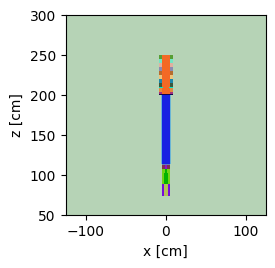

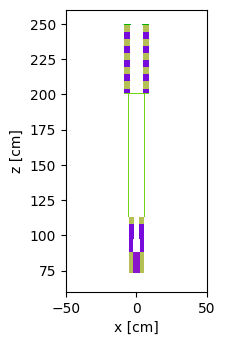

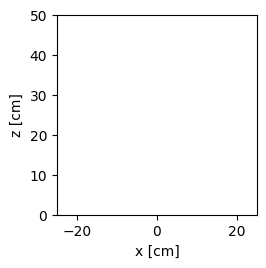

In [5]:
e_tapa_1=0.1
e_tapa_2=0.00001 #hay que sacar esta tapa que ya la meti en la CE
e_tapa_3=0.3
z_200=73.2
z_201=z_200+e_tapa_1
z_202=z_201+40
z_203=z_202+e_tapa_1
z_204=z_203+86.8
z_205=z_204+e_tapa_2
z_206=z_205+49.8
z_207=z_206+e_tapa_3
R_CI=5
R_tubo=5.5
e_tubo_1=0.3
e_tubo_2=0.2
R_CE=9


#Cilindro camara
cil_CI_in= openmc.ZCylinder(r=R_CI,y0=0,x0=0,surface_id=200, name="cil_1_tubo")
cil_CI_ext= openmc.ZCylinder(r=R_CI+e_tubo_1,y0=0,x0=0,surface_id=201, name="cil_2_tubo")
cil_tubo_in= openmc.ZCylinder(r=R_tubo,y0=0,x0=0,surface_id=202, name="cil_1_tubo")
cil_tubo_ext= openmc.ZCylinder(r=R_tubo+e_tubo_1,y0=0,x0=0,surface_id=203, name="cil_2_tubo")
cil_CE_in= openmc.ZCylinder(r=R_CE,y0=0,x0=0,surface_id=204, name="cil_1_tubo")
cil_CE_ext= openmc.ZCylinder(r=R_CE+e_tubo_2,y0=0,x0=0,surface_id=205, name="cil_2_tubo")
#planos de corte
planoZ0=openmc.ZPlane(z0=z_200,surface_id=206, name="plano_1")
planoZ1=openmc.ZPlane(z0=z_201,surface_id=207, name="plano_2")
planoZ2=openmc.ZPlane(z0=z_202,surface_id=208, name="plano_2")
planoZ3=openmc.ZPlane(z0=z_203,surface_id=209, name="plano_2")
planoZ4=openmc.ZPlane(z0=z_204,surface_id=210, name="plano_2")
planoZ5=openmc.ZPlane(z0=z_205,surface_id=211, name="plano_2")
planoZ6=openmc.ZPlane(z0=z_206,surface_id=212, name="plano_2")
planoZ7=openmc.ZPlane(z0=z_207,surface_id=213, name="plano_2")

#defino las regiones
cil_tapa_1 = (-cil_CI_ext & +planoZ0 & -planoZ1)
cil_CI = (+cil_CI_in & -cil_CI_ext & +planoZ1 & -planoZ2)
cil_tapa_2 = (-cil_tubo_ext & +planoZ2 & -planoZ3)
cil_tubo = (+cil_tubo_in & -cil_tubo_ext & +planoZ3 & -planoZ4)
cil_tapa_3 = (-cil_CE_ext & +planoZ4 & -planoZ5)
cil_CE = (+cil_CE_in & -cil_CE_ext & +planoZ5 & -planoZ6)
cil_tapa_4 = (-cil_CE_ext & +planoZ6 & -planoZ7)
in_CI= (-cil_CI_in  & +planoZ1 & -planoZ2 )
in_tubo = (-cil_tubo_in  & +planoZ3 & -planoZ4 )
in_CE= (-cil_CE_in & +planoZ5 & -planoZ6)
out_Contenedor = ~(cil_tapa_1|cil_CI |cil_tapa_2 |cil_tubo | cil_tapa_3 | cil_CE |cil_tapa_4 | in_CI| in_tubo | in_CE)

#defino celdas
cell_CI= openmc.Cell(region = cil_CI, fill = Al , cell_id = 200)
cell_tubo= openmc.Cell(region = cil_tubo, fill = Al , cell_id = 201)
cell_CE= openmc.Cell(region = cil_CE, fill = Al , cell_id = 202)
cell_tapa_1= openmc.Cell(region = cil_tapa_1, fill = Al , cell_id = 203)
cell_tapa_2= openmc.Cell(region = cil_tapa_2, fill = Al , cell_id = 204)
cell_tapa_3= openmc.Cell(region = cil_tapa_3, fill = Al , cell_id = 205)
cell_tapa_4= openmc.Cell(region = cil_tapa_4, fill = Al , cell_id = 206)
cell_in_CI= openmc.Cell(region = in_CI, fill = univ02, cell_id = 207)
cell_in_tubo= openmc.Cell(region = in_tubo, fill = None, cell_id = 210)
cell_in_CE= openmc.Cell(region = in_CE, fill = univ04 , cell_id = 208)
cell_out_Contenedor= openmc.Cell(region = out_Contenedor, fill = None , cell_id = 209)

univ03= openmc.Universe(cells = [cell_in_tubo,cell_in_CI,cell_in_CE,cell_out_Contenedor,cell_tubo,cell_CI,cell_CE,cell_tapa_1, cell_tapa_2, cell_tapa_3, cell_tapa_4], universe_id = 3)

univ03.plot(width = (250, 250),origin= (0,0,175), basis='xz')
univ03.plot(width = (100,200),origin= (0,0,160), basis='xz',color_by='material')
univ03.plot(width = (50,50),origin= (0,0,25), basis='xz',color_by='material')

## Universo 5 - Beam Catcher

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

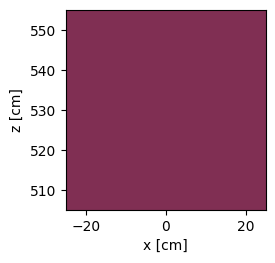

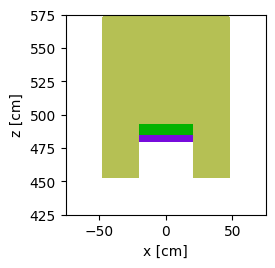

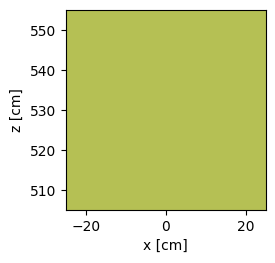

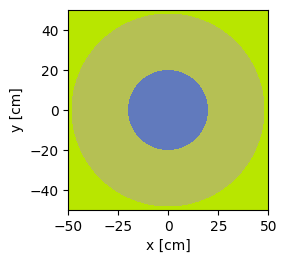

In [6]:
z_400=452+1
z_401=z_400+26.5             #Ver los 2mm
z_402=z_401+0.5
z_403=z_402+5
z_404=z_403+8
z_405=z_404+70+10
z_406=z_405+10
inicio_cono_beam=147.8431+z_400+10
R_beam=48.25
R_cavidad=20
x_400=-15
x_401=15
y_400=-11.75
y_401=11.75


#surf001=openmc.surface.Plane.from_points(p1,p2,p3) FALTA

#Cilindro beam
cil_beam= openmc.ZCylinder(r=R_beam,y0=0,x0=0,surface_id=400, name="cil_1")
#Cilindro cavidad
cil_cav= openmc.ZCylinder(r=R_cavidad,y0=0,x0=0,surface_id=401, name="cil_1")
#cono beam
cono_beam=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_beam, r2=1.62562503, surface_id=402, name="exp_in")
#planos de corte en z
planoZ_400=openmc.ZPlane(z0=z_400,surface_id=403, name="plano_1")
planoZ_401=openmc.ZPlane(z0=z_401,surface_id=404, name="plano_2")
planoZ_402=openmc.ZPlane(z0=z_402,surface_id=405, name="plano_2")
planoZ_403=openmc.ZPlane(z0=z_403,surface_id=406, name="plano_3")
planoZ_404=openmc.ZPlane(z0=z_404,surface_id=407, name="plano_3")
planoZ_405=openmc.ZPlane(z0=z_405,surface_id=408, name="plano_3")
planoZ_406=openmc.ZPlane(z0=z_406,surface_id=409, name="plano_3")

#planos de corte en x
planoX_400=openmc.XPlane(x0=x_400,surface_id=410, name="plano_2")
planoX_401=openmc.XPlane(x0=x_401,surface_id=411, name="plano_2")
#planos de corte en y
planoY_400=openmc.YPlane(y0=y_400,surface_id=412, name="plano_2")
planoY_401=openmc.YPlane(y0=y_401,surface_id=413, name="plano_2")

#defino las regiones
cil_beam_1 = (+cil_cav & -cil_beam & +planoZ_400 & -planoZ_402) #1
goma_litio =( +planoX_400 & -planoX_401 & +planoY_400 & -planoY_401 & +planoZ_401 & -planoZ_402) #2
cil_poliboro_beam = (-cil_cav & +planoZ_402 & -planoZ_403) #3
cil_Pb_beam = (-cil_cav & +planoZ_403 & -planoZ_404) #4
cil_beam_2 = (+cil_cav & -cil_beam & +planoZ_402 & -planoZ_404) #5
cil_beam_3 = (-cil_beam & +planoZ_404 & -planoZ_405) #6
Cono_beam = (-cono_beam &  +planoZ_405 & -planoZ_406) #7
cil_beam_in = (+planoZ_400 & -planoZ_402 & -cil_cav & ~goma_litio)
out_beam = (+cil_beam |  -planoZ_400  | +cono_beam | +planoZ_406 )


#defino celdas
cell_beam_1 = openmc.Cell(region = cil_beam_1, fill = Concreto , cell_id = 401)
cell_goma_litio = openmc.Cell(region =goma_litio , fill = poliboro  , cell_id = 402)
cell_poliboro_beam = openmc.Cell(region = cil_poliboro_beam , fill = poliboro , cell_id = 403)
cell_Pb_beam = openmc.Cell(region =cil_Pb_beam, fill = Pb  , cell_id = 404)
cell_beam_2 = openmc.Cell(region = cil_beam_2 , fill = Concreto , cell_id = 405)
cell_beam_3 = openmc.Cell(region =cil_beam_3 , fill = Concreto  , cell_id = 406)
cell_cono_beam = openmc.Cell(region = Cono_beam, fill = Concreto , cell_id = 407)
cell_cavidad =  openmc.Cell(region = cil_beam_in , fill = None , cell_id = 408)
cell_out = openmc.Cell(region = out_beam , fill = None , cell_id = 409)

univ05= openmc.Universe(cells = [cell_out, cell_cavidad,cell_beam_1,cell_beam_2,cell_beam_3, cell_cono_beam ,cell_goma_litio, cell_poliboro_beam, cell_Pb_beam], universe_id = 5)
#univ05= openmc.Universe(cells = [cell_out], universe_id = 4)

univ05.plot(width = (50, 50),origin= (0,0,530), basis='xz' )
univ05.plot(width = (150,150),origin= (0,0,500), basis='xz',color_by='material')
univ05.plot(width = (50,50),origin= (0,0,530), basis='xz',color_by='material')
univ05.plot(width = (100, 100),origin= (0,0,z_401), basis='xy' )

## UNIVERSO 6 - ESTRUCTURA INTERNA DEL BLINDAJE PRINCIPAL

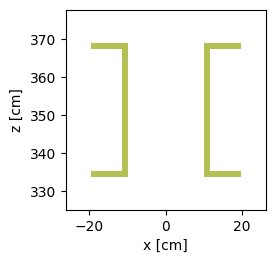

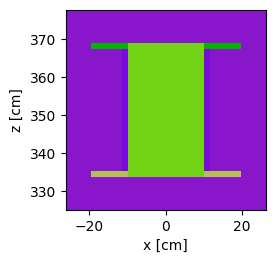

In [7]:
Z_INICIO_BP=303

z_500=23.4+7.5+Z_INICIO_BP
z_501=z_500+1.5
z_502=z_501+32
z_503=z_502+1.5

x_500=-19.75
x_501=-11.5
x_502=-10.0
x_503=10.0
x_504=11.5
x_505=19.75

y_500=-19.75
y_501=-11.5
y_502=-10.0
y_503=10.0
y_504=11.5
y_505=19.75

#planos de corte
planoZ_500=openmc.ZPlane(z0=z_500,surface_id=500, name="plano_1")
planoZ_501=openmc.ZPlane(z0=z_501,surface_id=501, name="plano_2")
planoZ_502=openmc.ZPlane(z0=z_502,surface_id=502, name="plano_2")
planoZ_503=openmc.ZPlane(z0=z_503,surface_id=503, name="plano_3")

planoX_500=openmc.XPlane(x0=x_500,surface_id=504, name="plano_1")
planoX_501=openmc.XPlane(x0=x_501,surface_id=505, name="plano_2")
planoX_502=openmc.XPlane(x0=x_502,surface_id=506, name="plano_2")
planoX_503=openmc.XPlane(x0=x_503,surface_id=507, name="plano_3")
planoX_504=openmc.XPlane(x0=x_504,surface_id=508, name="plano_1")
planoX_505=openmc.XPlane(x0=x_505,surface_id=509, name="plano_2")

planoY_500=openmc.YPlane(y0=y_500,surface_id=510, name="plano_1")
planoY_501=openmc.YPlane(y0=y_501,surface_id=511, name="plano_2")
planoY_502=openmc.YPlane(y0=y_502,surface_id=512, name="plano_2")
planoY_503=openmc.YPlane(y0=y_503,surface_id=513, name="plano_3")
planoY_504=openmc.YPlane(y0=y_504,surface_id=514, name="plano_1")
planoY_505=openmc.YPlane(y0=y_505,surface_id=515, name="plano_2")

#defino las regiones

cuadrado_inicio_in = (+planoZ_500 & -planoZ_501 & +planoX_502 & -planoX_503 & +planoY_502 & -planoY_503)#1
cuadrado_inicio_out = (+planoZ_500 & -planoZ_501 & +planoX_500 & -planoX_505 & +planoY_500 & -planoY_505)#1
cuadrado_inicio = (cuadrado_inicio_out & (~cuadrado_inicio_in))
#cuadrado_inicio = cuadrado_inicio_out

tubo_in = (+planoZ_501 & -planoZ_502 & +planoX_502 & -planoX_503 & +planoY_502 & -planoY_503)#1
tubo_out = (+planoZ_501 & -planoZ_502 & +planoX_501 & -planoX_504 & +planoY_501 & -planoY_504)#1
tubo= (tubo_out & (~tubo_in))

cuadrado_final_in = (+planoZ_502 & -planoZ_503 & +planoX_502 & -planoX_503 & +planoY_502 & -planoY_503)#1
cuadrado_final_out = (+planoZ_502 & -planoZ_503 & +planoX_500 & -planoX_505 & +planoY_500 & -planoY_505)#1
cuadrado_final = (cuadrado_final_out & (~cuadrado_final_in))

haz_in=(+planoZ_500 & -planoZ_503 & +planoX_502 & -planoX_503 & +planoY_502 & -planoY_503)


estructura_out=(~cuadrado_inicio & ~cuadrado_final & ~tubo & ~haz_in)


#defino celdas
cell_cuadrado_inicio = openmc.Cell(region = cuadrado_inicio , fill = poliboro  , cell_id = 500)
cell_tubo = openmc.Cell(region = tubo, fill = poliboro , cell_id = 501)
cell_cuadrado_final = openmc.Cell(region = cuadrado_final, fill = poliboro , cell_id = 502)
cell_in= openmc.Cell(region = haz_in, fill = None, cell_id = 503)
cell_estructura_out=openmc.Cell(region = estructura_out, fill = None, cell_id = 504)

univ06 = openmc.Universe(cells = [cell_in,cell_estructura_out,cell_cuadrado_inicio, cell_cuadrado_final, cell_tubo], universe_id = 6)

univ06.plot(width = [1.5*(z_503-z_500)]*2, origin= (0,0,0.5*(z_503+z_500)), basis='xz',color_by='material')
show()
univ06.plot(width = [1.5*(z_503-z_500)]*2, origin= (0,0,0.5*(z_503+z_500)), basis='xz',color_by='cell')
show()

## UNIVERSO 7 - CAJA ALUMINIO

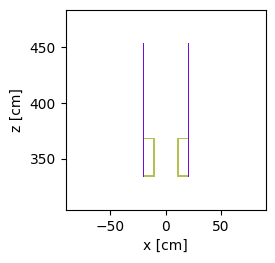

In [8]:
z_600=23.4+7.5+Z_INICIO_BP
z_601=z_600+120

x_600=-20.3
x_601=-20
x_602=20
x_603=20.3

y_600=-20.3
y_601=-20
y_602=20
y_603=20.3

#planos de corte
planoZ_600=openmc.ZPlane(z0=z_600,surface_id=600, name="plano_1")
planoZ_601=openmc.ZPlane(z0=z_601,surface_id=601, name="plano_2")

planoX_600=openmc.XPlane(x0=x_600,surface_id=603, name="plano_1")
planoX_601=openmc.XPlane(x0=x_601,surface_id=604, name="plano_2")
planoX_602=openmc.XPlane(x0=x_602,surface_id=605, name="plano_2")
planoX_603=openmc.XPlane(x0=x_603,surface_id=606, name="plano_3")

planoY_600=openmc.YPlane(y0=y_600,surface_id=607, name="plano_1")
planoY_601=openmc.YPlane(y0=y_601,surface_id=608, name="plano_2")
planoY_602=openmc.YPlane(y0=y_602,surface_id=609, name="plano_2")
planoY_603=openmc.YPlane(y0=y_603,surface_id=610, name="plano_3")


#defino las regiones

rectangulo_Al_in = (+planoZ_600 & -planoZ_601 & +planoX_601 & -planoX_602 & +planoY_601 & -planoY_602)#1
rectangulo_Al_out = (+planoZ_600 & -planoZ_601 & +planoX_600 & -planoX_603 & +planoY_600 & -planoY_603)#1
rectangulo_Al = (rectangulo_Al_out & (~rectangulo_Al_in))

IN_rectangulo=(+planoZ_600 & -planoZ_601 & +planoX_601 & -planoX_602 & +planoY_601 & -planoY_602)
OUT_rectangulo=(~rectangulo_Al & ~IN_rectangulo)


#defino celdas
cell_rectangulo_Al = openmc.Cell(region = rectangulo_Al, fill = Al  , cell_id = 600)
cell_in= openmc.Cell(region = IN_rectangulo, fill = univ06, cell_id = 601)
cell_rectangulo_Al_out=openmc.Cell(region = OUT_rectangulo, fill = None, cell_id = 602)

univ07 = openmc.Universe(cells = [cell_rectangulo_Al_out,cell_in,cell_rectangulo_Al], universe_id = 7)

# univ07.plot(width = (130,130),origin= (0,0,90), basis='xz')
univ07.plot(width = [1.5*(z_601-z_600)]*2 ,origin= (0,0,0.5*(z_600+z_601)), basis='xz',color_by='material')
show()

## UNIVERSO 8 - CAJA POLIBORO

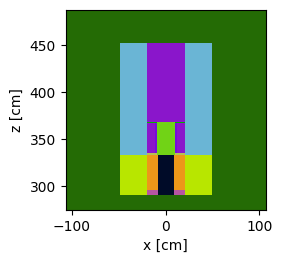

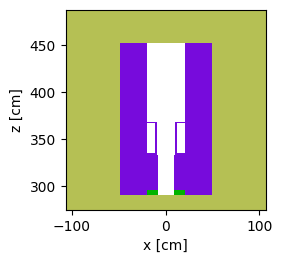

In [9]:
z_700=Z_INICIO_BP+7.5
z_701=z_700+23.4
z_702=z_701+118.6

x_700=-48.5
x_701=-20.3
x_702=20.3
x_703=48.5

y_700=-48.5
y_701=-20.3
y_702=20.3
y_703=48.5


Z_SHUTTER=290.0
z_790=Z_SHUTTER+1.0
z_791=z_790+5.0
z_792=z_701

x_790=-8.0
x_791=8.0
y_790=x_790
y_791=x_791


#planos de corte
planoZ_700=openmc.ZPlane(z0=z_700,surface_id=700, name="plano_1")
planoZ_701=openmc.ZPlane(z0=z_701,surface_id=701, name="plano_2")
planoZ_702=openmc.ZPlane(z0=z_702,surface_id=702, name="plano_2")

planoX_700=openmc.XPlane(x0=x_700,surface_id=703, name="plano_1")
planoX_701=openmc.XPlane(x0=x_701,surface_id=704, name="plano_2")
planoX_702=openmc.XPlane(x0=x_702,surface_id=705, name="plano_2")
planoX_703=openmc.XPlane(x0=x_703,surface_id=706, name="plano_3")

planoY_700=openmc.YPlane(y0=y_700,surface_id=707, name="plano_1")
planoY_701=openmc.YPlane(y0=y_701,surface_id=708, name="plano_2")
planoY_702=openmc.YPlane(y0=y_702,surface_id=709, name="plano_2")
planoY_703=openmc.YPlane(y0=y_703,surface_id=710, name="plano_3")



planoZ_790=openmc.ZPlane(z0=z_790,surface_id=790)
planoZ_791=openmc.ZPlane(z0=z_791,surface_id=791)
planoZ_792=openmc.ZPlane(z0=z_792,surface_id=792)

planoX_790=planoX_701
planoX_791=openmc.XPlane(x0=x_790,surface_id=793)
planoX_792=openmc.XPlane(x0=x_791,surface_id=794)
planoX_793=planoX_702

planoY_790=planoY_701
planoY_791=openmc.YPlane(y0=y_790,surface_id=795)
planoY_792=openmc.YPlane(y0=y_791,surface_id=796)
planoY_793=planoY_702

# plano_inclinado=openmc.Plane.from_points(p1=(-48.5,0,18.9+Z_INICIO_BP),p2=(-48.5,48.5,18.9+Z_INICIO_BP),p3=(48.5,0,Z_INICIO_BP), surface_id=711, name="plano_inclinado")
# plano_inclinado=openmc.ZPlane(z0=289.3,surface_id=711)
# plano_inclinado=openmc.Plane.from_points(p1=(-48.5,0,Z_SHUTTER),p2=(-48.5,48.5,Z_SHUTTER),p3=(48.5,0,Z_SHUTTER), surface_id=711, name="plano_inclinado")
#defino las regiones

# plano_inclinado_in = (-plano_inclinado & -planoZ_701 & +planoX_701 & -planoX_702 & +planoY_701 & -planoY_702)#1
bodoque_1_in = +planoZ_790 & -planoZ_791 & +planoX_791 & -planoX_792 & +planoY_791 & -planoY_792
bodoque_1_out= +planoZ_790 & -planoZ_791 & +planoX_790 & -planoX_793 & +planoY_790 & -planoY_793
bodoque_1 = bodoque_1_out & (~bodoque_1_in)

bodoque_2_in = +planoZ_791 & -planoZ_792 & +planoX_791 & -planoX_792 & +planoY_791 & -planoY_792
bodoque_2_out= +planoZ_791 & -planoZ_792 & +planoX_790 & -planoX_793 & +planoY_790 & -planoY_793
bodoque_2 = bodoque_2_out & (~bodoque_2_in)

bodoque_haz = bodoque_1_in | bodoque_2_in

blinextra_in = bodoque_1 | bodoque_2 | bodoque_haz
# blinextra_out = (-plano_inclinado & -planoZ_701 & +planoX_700 & -planoX_703 & +planoY_700 & -planoY_703)
blinextra_out = (+planoZ_790 & -planoZ_701 & +planoX_700 & -planoX_703 & +planoY_700 & -planoY_703)
blinextra = blinextra_out & ~blinextra_in#(~plano_inclinado_in))


caja_in=(+planoZ_701 & -planoZ_702 & +planoX_701 & -planoX_702 & +planoY_701 & -planoY_702)
caja_out=(+planoZ_701 & -planoZ_702 & +planoX_700 & -planoX_703 & +planoY_700 & -planoY_703)
caja=(caja_out & (~caja_in))

IN_caja=(+planoZ_701 & -planoZ_702 & +planoX_701 & -planoX_702 & +planoY_701 & -planoY_702)#(-plano_inclinado & -planoZ_702 & +planoX_701 & -planoX_702 & +planoY_701 & -planoY_702)
OUT_caja=(~blinextra_out & ~caja & ~IN_caja )





#defino celdas
cell_bodoque_1=openmc.Cell(region = bodoque_1 , fill=Pb, cell_id=790)
cell_bodoque_2=openmc.Cell(region = bodoque_2 , fill=poliboro, cell_id=791)
cell_bodoque_haz=openmc.Cell(region = bodoque_haz, fill=None, cell_id=792)

# cell_plano_inclinado = openmc.Cell(region = p_inclinado, fill = poliboro  , cell_id = 700)
cell_blinextra = openmc.Cell(region = blinextra , fill=poliboro,  cell_id=700)
cell_caja = openmc.Cell(region = caja, fill = poliboro  , cell_id = 701)
cell_IN = openmc.Cell(region = IN_caja, fill = univ07  , cell_id = 702)
cell_OUT= openmc.Cell(region = OUT_caja, fill = mat01, cell_id = 703)
#cell_rectangulo_Al_out=openmc.Cell(region = OUT_rectangulo, fill = None, cell_id = 602)



# univ08 = openmc.Universe(cells = [cell_OUT,cell_IN,cell_caja,cell_plano_inclinado], universe_id = 8)
# univ08 = openmc.Universe(cells = [cell_OUT,cell_IN,cell_caja,cell_blinextra,cell_bodoque_1,cell_bodoque_2,cell_bodoque_haz], universe_id = 8)
univ08 = openmc.Universe(cells = [cell_OUT,cell_IN,cell_caja,cell_blinextra,cell_bodoque_1,cell_bodoque_2,cell_bodoque_haz], universe_id = 8)

#univ08.plot(width = (200,200),origin= (0,0,60), basis='xz')
univ08.plot(width = [1.5*(z_702-z_700)]*2,origin= (0,0,0.5*(z_700+z_702)), basis='xz',color_by='cell')
show()

univ08.plot(width = [1.5*(z_702-z_700)]*2,origin= (0,0,0.5*(z_700+z_702)), basis='xz',color_by='material')
show()

## UNIVERSO 9 - BLINDAJE Pb

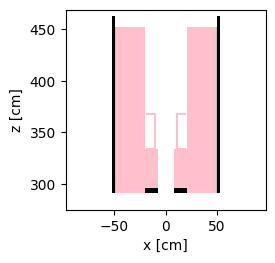

In [10]:
# z_800=Z_INICIO_BP
z_800=z_790
z_801=Z_INICIO_BP+23.6
z_802=z_801+130.3-4
z_plomos=z_802+10

x_800=-52
x_801=-52+2.24
x_802=52-2.24
x_803=52

y_800=-52
y_801=-52+2.24
y_802=+52-2.24
y_803=52

#planos de corte
planoZ_800=openmc.ZPlane(z0=z_800,surface_id=800, name="plano_1")
planoZ_801=openmc.ZPlane(z0=z_801,surface_id=801, name="plano_2")
planoZ_802=openmc.ZPlane(z0=z_802,surface_id=802, name="plano_2")
planoZ_803=openmc.ZPlane(z0=z_plomos,surface_id=811, name="plano_2")

planoX_800=openmc.XPlane(x0=x_800,surface_id=803, name="plano_1")
planoX_801=openmc.XPlane(x0=x_801,surface_id=804, name="plano_2")
planoX_802=openmc.XPlane(x0=x_802,surface_id=805, name="plano_2")
planoX_803=openmc.XPlane(x0=x_803,surface_id=806, name="plano_3")

planoY_800=openmc.YPlane(y0=y_800,surface_id=807, name="plano_1")
planoY_801=openmc.YPlane(y0=y_801,surface_id=808, name="plano_2")
planoY_802=openmc.YPlane(y0=y_802,surface_id=809, name="plano_2")
planoY_803=openmc.YPlane(y0=y_803,surface_id=810, name="plano_3")

# plano_inclinado_1 = plano_inclinado
#plano_inclinado_1=openmc.Plane.from_points(p1=(-52,0,18.9+Z_INICIO_BP),p2=(-52,52,18.9+Z_INICIO_BP),p3=(52,0,Z_INICIO_BP), surface_id=811, name="plano_inclinado")
# plano_inclinado_2=openmc.Plane.from_points(p1=(-49.76,0,25.388642+Z_INICIO_BP),p2=(-49.76,49.76,25.388642+Z_INICIO_BP),p3=(49.76,0,2.296949+Z_INICIO_BP), surface_id=812, name="plano_inclinado")
#defino las regiones

#plano_inclinado_in = (-plano_inclinado & -planoZ_701 & +planoX_701 & -planoX_702 & +planoY_701 & -planoY_702)#1
#plano_inclinado_out = (-plano_inclinado & -planoZ_701 & +planoX_700 & -planoX_703 & +planoY_700 & -planoY_703)
#p_inclinado = (plano_inclinado_out & (~plano_inclinado_in))

# caja_in=(-plano_inclinado_1 & -planoZ_802 & +planoX_801 & -planoX_802 & +planoY_801 & -planoY_802)
# caja_out=(-plano_inclinado_1 & -planoZ_802  & +planoX_800 & -planoX_803 & +planoY_800 & -planoY_803)
# caja=(caja_out & (~caja_in))
# IN_caja=(-plano_inclinado_1 & -planoZ_802 & +planoX_801 & -planoX_802 & +planoY_801 & -planoY_802)
# OUT_caja=(~caja & ~IN_caja )

caja_in=(+planoZ_800 & -planoZ_803 & +planoX_801 & -planoX_802 & +planoY_801 & -planoY_802)
caja_out=(+planoZ_800 & -planoZ_803  & +planoX_800 & -planoX_803 & +planoY_800 & -planoY_803)
caja=(caja_out & (~caja_in))
IN_caja=(+planoZ_800 & -planoZ_802 & +planoX_801 & -planoX_802 & +planoY_801 & -planoY_802)
OUT_caja=(~caja & ~IN_caja )


#defino celdas
#cell_plano_inclinado = openmc.Cell(region = p_inclinado, fill = poliboro  , cell_id = 800)
cell_caja = openmc.Cell(region = caja, fill = Pb  , cell_id = 800)
cell_IN = openmc.Cell(region = IN_caja, fill = univ08  , cell_id = 801)
cell_OUT= openmc.Cell(region = OUT_caja, fill = None, cell_id = 802)
#cell_rectangulo_Al_out=openmc.Cell(region = OUT_rectangulo, fill = None, cell_id = 602)

univ09 = openmc.Universe(cells = [cell_caja, cell_IN, cell_OUT], universe_id = 9)

materials_colors={mat01:'silver', Al:'gray',Concreto:'orange',Pb:'black',poliboro:'pink',  H2O:'lightblue', Cd:'Red', mat05:'green'} #, None:'white'}


#univ09.plot(width = (180,180),origin= (0,0,80), basis='xz')
univ09.plot(width = [1.2*(z_802-z_800)]*2,origin= (0,0,0.5*(z_800+z_802)), basis='xz',color_by='material', colors=materials_colors , pixels=(200,200))
show()
#plt.savefig('BP.pdf')

## UNIVERSO 1 - CONDUCTO 1

250.3

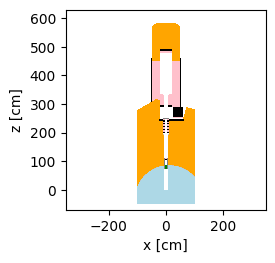

In [11]:
#aca pongo todas las superficies que van a luego formar las regiones.
z_0=0  #salida del nucleo
z_TRACK=z_0+69.5889
z_1=z_0+86.5596           #salida pileta
z_2=z_1+26.5404           #brida
z_3=z_2+71.8               #comienzo cono
z_4=z_3+15.1               #fin cono
z_5=z_4+49.8               #fin tubo
z_6= z_5 +0.5
R_int_1=6.41
e1=0.655 #VERIFICAR CON PLANOS
R_int_2=10.136
e2=0.818
inicio_cono_int=z_2+45.8228
inicio_cono_ext=z_2+44.3684
H=200 #esto es para hacer como una caja de concreto
H_x=200
z_agua=z_0-33.7722
#z_agua=z_0-35.665264
x_agua=10.6252
R_agua=120
#z_agua=0
#x_agua=0

#beam catcher contenedor
z_beam_1=452+1
z_beam_2=z_beam_1+130
D_beam=96.5
z_caja_1= z_0 -50
z_caja_2= z_beam_2 +200
#Tubo saliente de pileta
cil_int_1= openmc.ZCylinder(r=R_int_1,y0=0,x0=0,surface_id=1, name="cil_1")
cil_ext_1= openmc.ZCylinder(r=R_int_1+e1,y0=0,x0=0,surface_id=2, name="cil_2")
#Expansion
exp_in=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_int, r2=0.0609, surface_id=3, name="exp_in")          #VER R2 COMO SE RELACIONA CON EL ANGULO
exp_ext=openmc.ZCone(x0=0.0, y0=0.0, z0=inicio_cono_ext, r2=0.0663,surface_id=4, name="exp_ext")            #VER R2 COMO SE RELACIONA CON EL ANGULO
#Tubo post expansion
cil_int_2= openmc.ZCylinder(r=R_int_2,y0=0,x0=0,surface_id=5, name="cil_3")
cil_ext_2= openmc.ZCylinder(r=R_int_2+e2,y0=0,x0=0,surface_id=6, name="cil_4")
#planos de corte
planoZ_0=openmc.ZPlane(z0=z_0,surface_id=7, name="plano_1")
planoZ_TRACK=openmc.ZPlane(z0=z_TRACK,surface_id=6900, name="plano_z_track", boundary_type="vacuum")
planoZ_1=openmc.ZPlane(z0=z_1,surface_id=8, name="plano_2")
planoZ_3=openmc.ZPlane(z0=z_3,surface_id=9, name="plano_2")
planoZ_4=openmc.ZPlane(z0=z_4,surface_id=10 ,name="plano_3")
planoZ_5=openmc.ZPlane(z0=z_5,surface_id=11 , name="plano_4")
planoZ_6=openmc.ZPlane(z0=z_6,surface_id=32 , name="plano_4")
#cubo centrado en (H/2,H/2,H/2)
planoY_0=openmc.YPlane(y0=-H/2,surface_id=12, name="plano_cubo_1", boundary_type = "vacuum")
planoY_H=openmc.YPlane(y0=H/2,surface_id=13, name="plano_cubo_2", boundary_type = "vacuum")
planoX_0=openmc.XPlane(x0=-H_x/2,surface_id=30, name="plano_cubo_1", boundary_type = "vacuum")
planoX_H=openmc.XPlane(x0=H_x/2,surface_id=31, name="plano_cubo_2", boundary_type = "vacuum")
#pileta agua en x

cil_agua= openmc.YCylinder(r=R_agua,z0=z_agua,x0=x_agua,surface_id=16, name="cil_agua")
cil_acero=  openmc.YCylinder(r=R_agua+0.8,z0=z_agua,x0=x_agua,surface_id=99, name="cil_agua")
#beam catcher
cil_beam= openmc.ZCylinder(r=D_beam/2,y0=0,x0=0,surface_id=17, name="cil_beam")
planoZ_beam_1=openmc.ZPlane(z0=z_beam_1,surface_id=18 ,name="plano_beam_1")
planoZ_beam_2=openmc.ZPlane(z0=z_beam_2,surface_id=19 , name="plano_beam_2")

planoZ_caja_1=openmc.ZPlane(z0=z_caja_1,surface_id=28 ,name="plano_beam_1" ,boundary_type = "vacuum")
planoZ_caja_2=openmc.ZPlane(z0=z_caja_2,surface_id=29 , name="plano_beam_2" ,boundary_type = "vacuum")

# Defino el origen
x0=x_agua/2
y0=z_agua/2
z0=0
origen=array([x0,y0,z0])

# Defino la inclinación y las matrices de rotación
inclinacion=-15 # grados
angulos=deg2rad(linspace(0,360,9)+inclinacion)
mat_xy=array([[cos(angulos[0]),-sin(angulos[0]),0],
               [sin(angulos[0]), cos(angulos[0]),0],
               [0,0,1]])
mat_xz=array([[ cos(angulos[0]),0,sin(angulos[0])],
               [0,1,0],
               [-sin(angulos[0]),0,cos(angulos[0])]])
mat_yz=array([[1,0,0],
               [0,cos(angulos[0]),-sin(angulos[0])],
               [0,sin(angulos[0]), cos(angulos[0])]])

# Defino el apotema del octógono
apot=650/2.0

# Defino los ocho puntos 'fijos' del octógono
puntos=array([array([+apot,0,0]),
               array([+apot/sqrt(2),+apot/sqrt(2),0]),
               array([0,+apot,0]),
               array([-apot/sqrt(2),+apot/sqrt(2),0]),
               array([-apot,0,0]),
               array([-apot/sqrt(2),-apot/sqrt(2),0]),
               array([0,-apot,0]),
               array([+apot/sqrt(2),-apot/sqrt(2),0])])

#aux=copy(puntos)
#aux[:,1]=aux[:,2]
#aux[:,2]=puntos[:,1]
#puntos=aux
# Roto y traslado (en ese orden) los puntos
puntos=dot(mat_xz,puntos.T).T
puntos+=origen


# Genero los planos
planos=[]
for i,(ang,x0) in enumerate(zip(angulos, puntos)):
    vnorm = array([cos(ang), sin(ang), 0])
    planos.append(openmc.Plane(a=vnorm[0],b=vnorm[2],c=vnorm[1],d=np.dot(vnorm,x0),surface_id=9000+i))

# Genero la región
octogono_in=(-planos[0]&-planos[1]&-planos[2]&-planos[3]&-planos[4]&-planos[5]&-planos[6]&-planos[7])
octogono_out=~octogono_in

#Corte del octogono
planoX_1=openmc.XPlane(x0=-20 ,surface_id=20, name="plano_cubo_3")
Plano_corte_1=openmc.Plane.from_points(p1=(60,0,z_5),p2=(60,-H,z_5),p3=(72.244591,0,z_5+43.687635 ), surface_id=21, name="cono_P_1")
planoZ_corte_oct=openmc.ZPlane(z0=z_5-2,surface_id=22 , name="plano_beam_2")

planoZ_Pb=openmc.ZPlane(z0=z_5-7-2,surface_id=23 , name="plano_beam_2")
planoX_Pb_1=openmc.XPlane(x0=-23 ,surface_id=24, name="plano_cubo_3")
planoX_Pb_2=openmc.XPlane(x0=+63 ,surface_id=25, name="plano_cubo_3")
planoY_Pb_1=openmc.YPlane(y0=-28,surface_id=26, name="plano_cubo_1")
planoY_Pb_2=openmc.YPlane(y0=+28,surface_id=27, name="plano_cubo_2")

#SHUTTER
XSHUTTER=37.0+3.5+1
Plano_Zshutter_poli=openmc.ZPlane(z0=z_5,surface_id=5029)
Plano_Zshutter_1=openmc.ZPlane(z0=z_5+3.5+2,surface_id=5030)
Plano_Zshutter_2=openmc.ZPlane(z0=z_5+3.5+34.0+2,surface_id=5031)
Plano_Xshutter_1=openmc.XPlane(x0=XSHUTTER-37.0/2,surface_id=5032)
Plano_Xshutter_2=openmc.XPlane(x0=XSHUTTER+37.0/2,surface_id=5033)
Plano_Yshutter_1=openmc.YPlane(y0=-45.0/2,surface_id=5034)
Plano_Yshutter_2=openmc.YPlane(y0=45.0/2,surface_id=5035)



#defino las regiones
cil_1 = +cil_int_1 & -cil_ext_1 & +planoZ_0  & -planoZ_3#1
cil_1_int = -cil_int_1 & +planoZ_0 & -planoZ_3 #2
cil_1_out =  +cil_ext_1 | -planoZ_0 | +planoZ_3

cono = +exp_in & -exp_ext & +planoZ_3 & -planoZ_4 #3
cono_int = -exp_in & +planoZ_3 & -planoZ_4#4
cono_out = +exp_ext | -planoZ_3 | +planoZ_4

tapa_cil_2= -cil_ext_2 & +planoZ_5 & -planoZ_6
cil_2 = +cil_int_2 & -cil_ext_2 & +planoZ_4 & -planoZ_5 #5
cil_2_int = -cil_int_2 & +planoZ_4 & -planoZ_5#6
cil_2_out = +cil_ext_2 | -planoZ_4 | +planoZ_5

pileta= (-cil_agua & +planoZ_caja_1 & +planoX_0 & -planoX_H & +planoY_0 & -planoY_H) & cil_1_out
acero= (+cil_agua & -cil_acero & +planoZ_caja_1 & +planoX_0 & -planoX_H & +planoY_0 & -planoY_H) & cil_1_out

Plomo=(cil_2_out & +planoY_Pb_1 & -planoY_Pb_2 & +planoX_Pb_1 & -planoX_Pb_2 & +planoZ_Pb & -planoZ_corte_oct )

Shutter_1 = (+Plano_Zshutter_1 & -Plano_Zshutter_2 & +Plano_Xshutter_1 & -Plano_Xshutter_2 & +Plano_Yshutter_1 & -Plano_Yshutter_2 )
Shutter_2 = (+planoZ_6 & -Plano_Zshutter_1 & +Plano_Xshutter_1 & -Plano_Xshutter_2 & +Plano_Yshutter_1 & -Plano_Yshutter_2 )
Shutter_out = ~(Shutter_1 | Shutter_2)


corte_oct_3=(+cil_ext_2 & +planoY_0 & -planoY_H & +planoX_1 & +Plano_corte_1 & +planoZ_5 & -planoZ_6)
corte_oct_2=(+cil_ext_2 & +planoY_0 & -planoY_H & +planoX_1 & +Plano_corte_1 & +planoZ_corte_oct & -planoZ_5)
corte_oct_1=(octogono_in & +planoY_0 & -planoY_H & +planoX_1 & +Plano_corte_1 & +planoZ_6)

OCTOGONO = octogono_in &  cil_1_out & cil_2_out & cono_out & +planoY_0 & -planoY_H & +planoX_0 & -planoX_H & +planoZ_caja_1 & ~(pileta|acero|corte_oct_1|corte_oct_2|corte_oct_3|Plomo|tapa_cil_2)

beam=(-cil_beam &  +planoZ_beam_1 & -planoZ_beam_2)
beam_out= (+cil_beam | -planoZ_beam_1  |+ planoZ_beam_2 )

hall= ((octogono_out  & beam_out & +planoX_0 & -planoX_H& +planoY_0 & -planoY_H & +planoZ_caja_1 & -planoZ_caja_2) | corte_oct_1 | corte_oct_2|corte_oct_3)& Shutter_out

cell_cil_1 = openmc.Cell(region = cil_1 , fill = mat01, cell_id = 1)
cell_cono = openmc.Cell(region = cono, fill = mat01 , cell_id = 2)
cell_cil_2 = openmc.Cell(region = cil_2 , fill = mat01  , cell_id = 3)
cell_interna = openmc.Cell(region=cil_1_int|cil_2_int|cono_int,fill=univ03 , cell_id=7)

cell_acero= openmc.Cell(region=acero,fill=mat01 , cell_id=854)
cell_pileta = openmc.Cell(region=pileta,fill=H2O , cell_id=8)
cell_octogono = openmc.Cell(region=OCTOGONO,fill=Concreto , cell_id=9)
cell_beam = openmc.Cell(region=beam,fill=univ05 , cell_id=10)
cell_hall = openmc.Cell(region=hall,fill=univ09 , cell_id=11)
cell_Pb = openmc.Cell(region=Plomo,fill=Pb , cell_id=12)
cell_Shutter_1 = openmc.Cell(region=Shutter_1,fill=Pb , cell_id=13)
cell_Shutter_2 = openmc.Cell(region=Shutter_2,fill=poliboro , cell_id=14)
cell_tapa = openmc.Cell(region = tapa_cil_2 , fill = Al  , cell_id = 15)



#cell_prueba=openmc.Cell(region = ~(cil_1|cono|cil_2|cil_1_int|cil_2_int|cono_int) , fill = None  , cell_id = 16)

univ01 = openmc.Universe(cells = [cell_cil_1, cell_cono, cell_cil_2, cell_interna, cell_acero, cell_pileta, cell_octogono, cell_beam, cell_hall, cell_Pb, cell_Shutter_1, cell_Shutter_2, cell_tapa], universe_id = 1)

materials_colors={mat01:'silver', Al:'gray',Concreto:'orange',Pb:'black',poliboro:'pink',  H2O:'lightblue', Cd:'Red', mat05:'green'}

#univ01.plot(width = (700, 700),origin= (0,0,280), basis='xz')
#univ01.plot(width = (300,300),origin= (0,0,270), basis='xz',color_by='material',pixels=(400, 400))
univ01.plot(width = (700, 700),origin= (0,0,280), basis='xz',color_by='material', colors=materials_colors)
# savefig('geometry_cell.jpg')
#plot_univ.legend()
#plt.savefig('conducto_1.jpg')
z_6

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


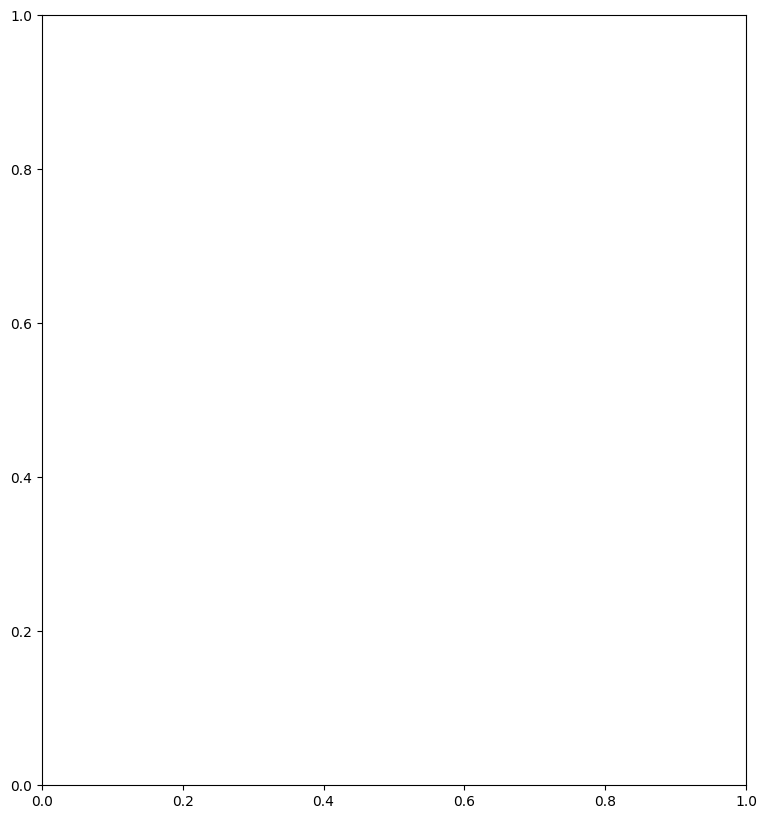

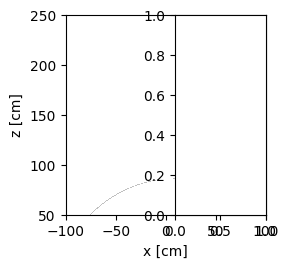

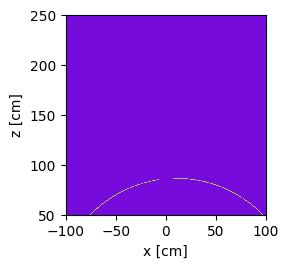

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9990.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


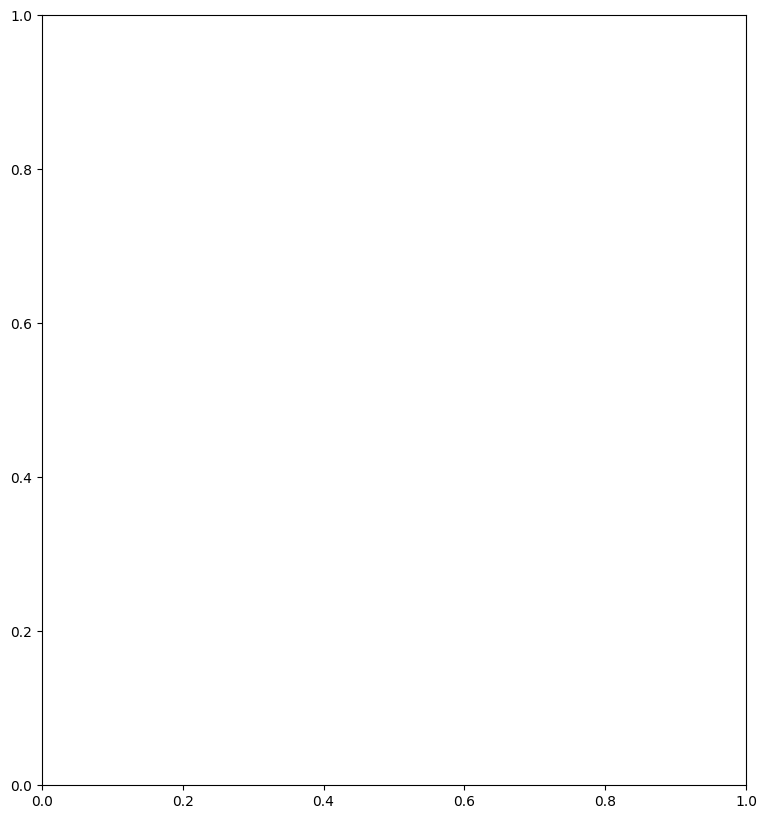

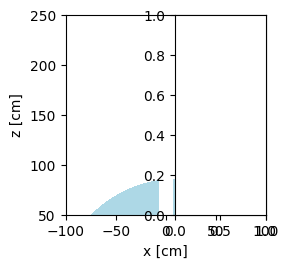

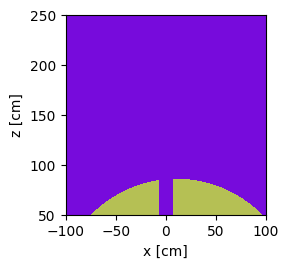

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9990.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


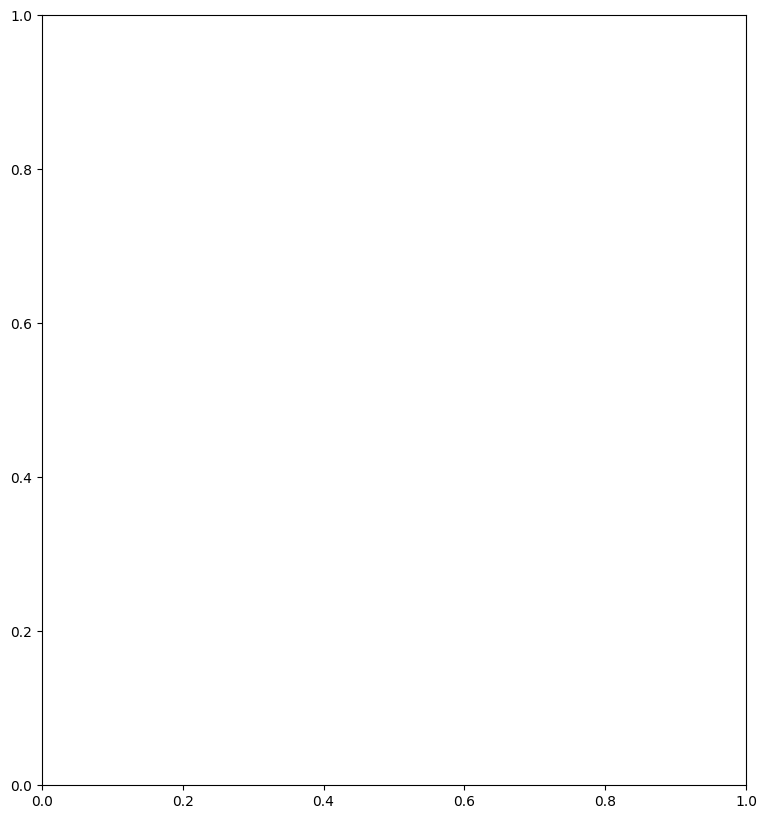

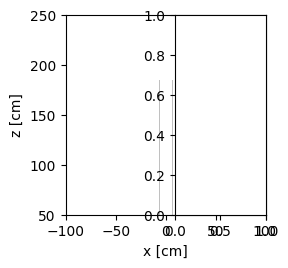

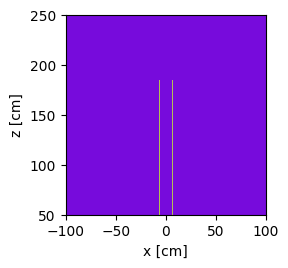

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9990.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


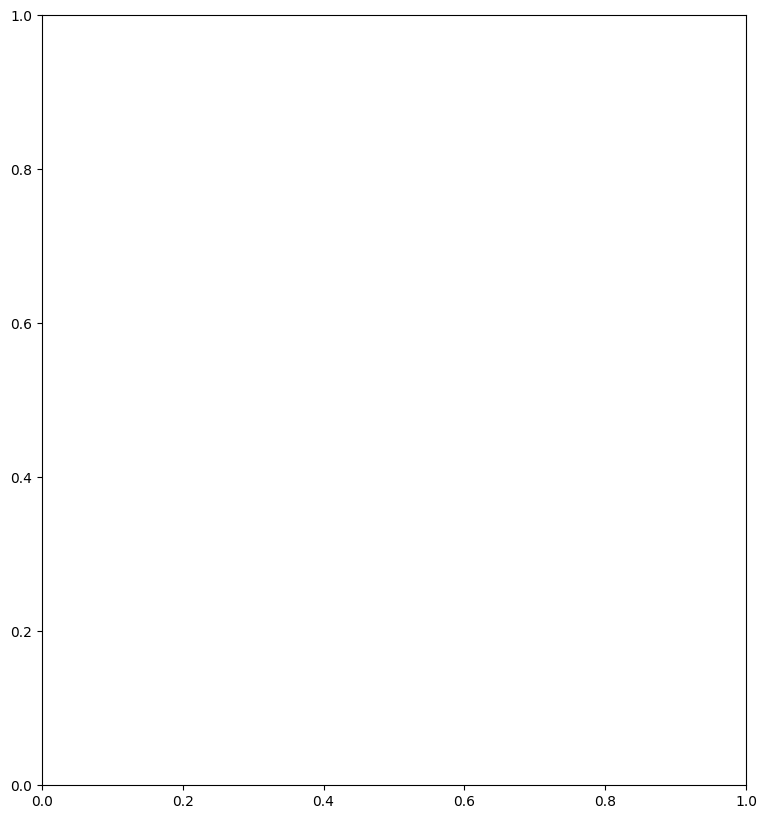

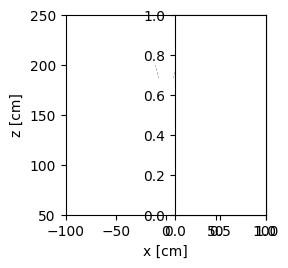

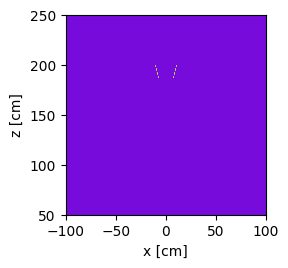

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9990.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


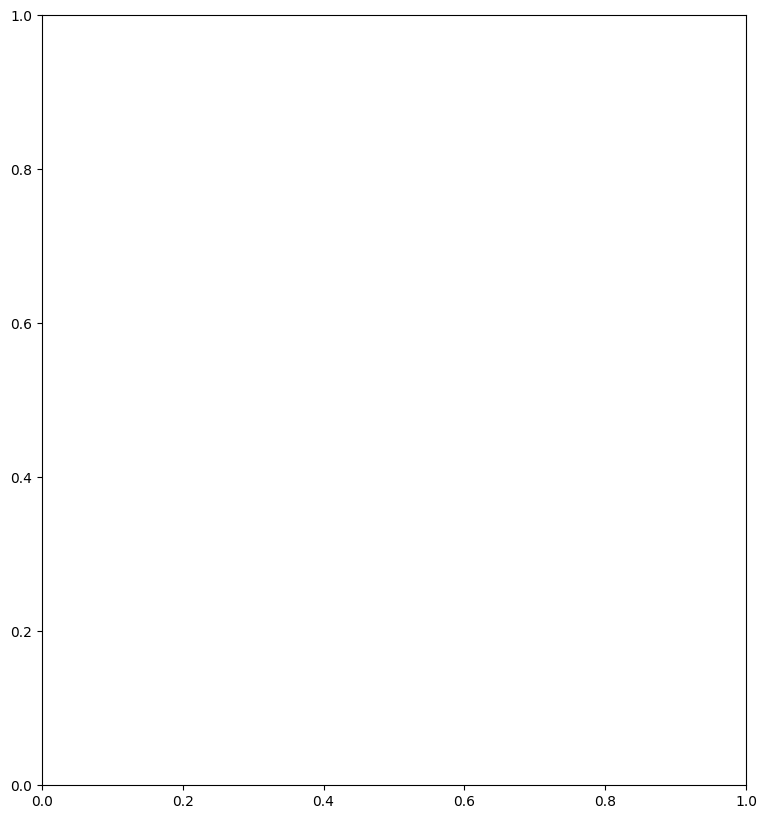

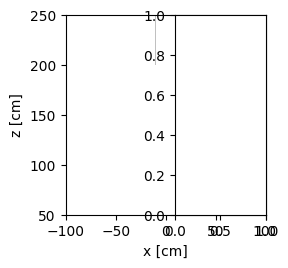

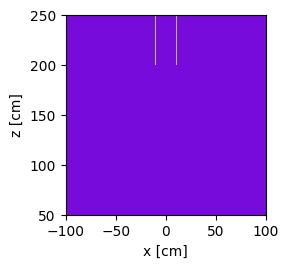

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9990.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


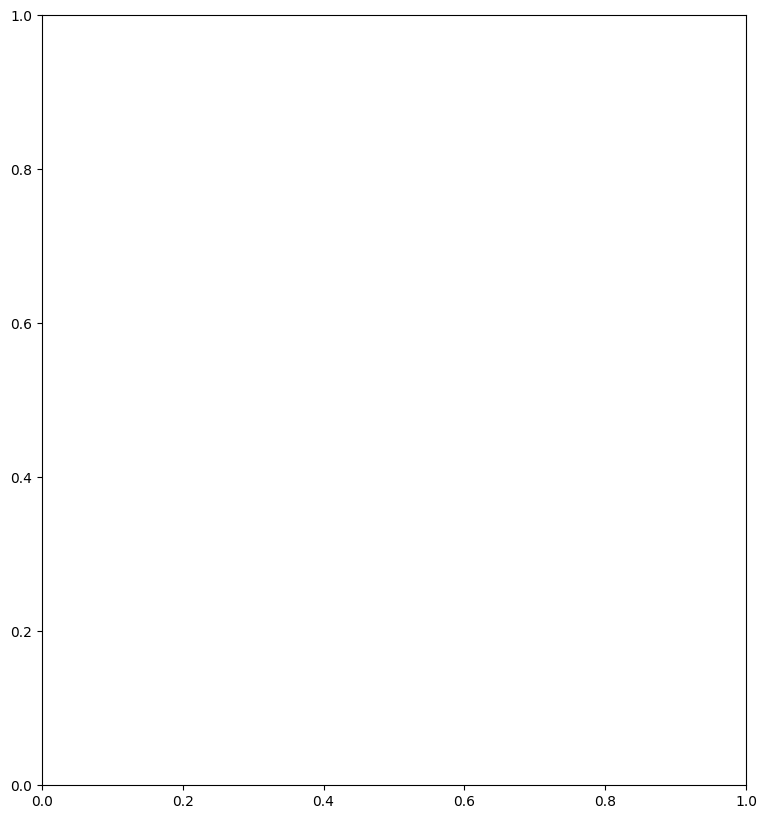

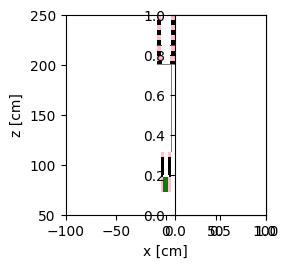

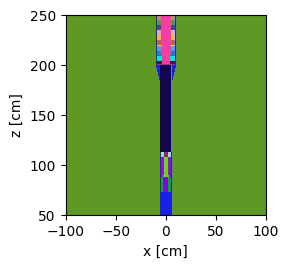

In [12]:
plt.rcParams['figure.figsize']=(20,10)
for cell_test in  [cell_acero,cell_pileta, cell_cil_1,cell_cono,cell_cil_2, cell_interna]:
    cell_aux=openmc.Cell(region=~(cell_test.region),fill=None,cell_id=9990)
    univ_aux= openmc.Universe(cells = [cell_test,cell_aux], universe_id = 1)

    materials_colors={mat01:'silver', Al:'gray',Concreto:'orange',Pb:'black',poliboro:'pink',  H2O:'lightblue', Cd:'Red', mat05:'green'}
    plt.subplot(121)
    univ_aux.plot(width = (200, 200),origin= (0,0,150), basis='xz',color_by='material', colors=materials_colors)
    plt.subplot(122)
    univ_aux.plot(width = (200, 200),origin= (0,0,150), basis='xz',color_by='cell')
    plt.show()

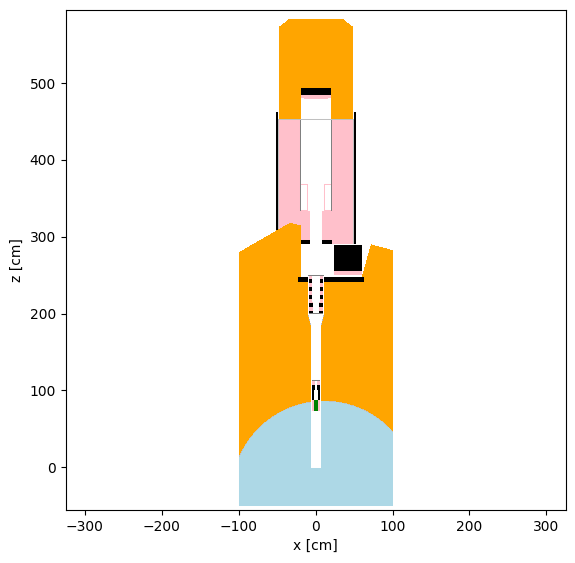

In [13]:
plt.rcParams['figure.figsize']=(9,9)
univ01.plot(width = (650,650),origin= (0,0,270), basis='xz',color_by='material',pixels=(500, 500), colors=materials_colors)
plt.savefig('geometry.jpg')
plt.show()

In [14]:
z_5+3.5+34.0+2

289.3

In [15]:
TRAC_a = kds.SurfaceSourceFile('track_Colimador.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'track_Colimador.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:


neutrones = TRAC_a.Filter_Sourface_Source({'type':[2112,2113]})

In [ ]:
neutrones.get_pandas_dataframe()
neutrones.save_source_file("neutrones.mcpl")

Saving into MCPL format
Saving into SSV format (ASCII)
Done, saved into temp.txt file
ssv_open_file: Opened file "temp.txt":
MCPL: Attempting to compress file neutrones.mcpl with gzip
MCPL: Succesfully compressed file into neutrones.mcpl.gz
Created neutrones.mcpl.gz
Done, saved into neutrones.mcpl file


In [ ]:
neutrones._S0

3.7531202905678156

In [ ]:
track = neutrones.get_pandas_dataframe()

In [ ]:
track["wgt"]

2         0.797511
4         0.992280
21        0.532966
24        0.925725
25        0.354847
            ...   
229636    0.492873
229638    0.693176
229643    0.999413
229646    0.673675
229649    1.000000
Name: wgt, Length: 63862, dtype: float64

In [ ]:
track["z"]=69.58906
track

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
2,2,2112,3.551810e-08,0.777035,-3.089200,69.58906,0.063570,-0.016737,0.997837,0.5,...,0.0,0,3.185426,-1.324376,0.997837,0.065784,-0.257447,20.148956,-0.30103,1.517620
4,4,2112,4.248890e+00,-4.282019,0.241886,69.58906,0.017673,0.008828,0.999805,0.5,...,0.0,0,4.288845,3.085164,0.999805,0.019757,0.463240,1.549075,-0.30103,0.000139
21,21,2112,4.009770e-08,0.436134,1.290980,69.58906,0.061817,-0.036065,0.997436,0.5,...,0.0,0,1.362660,1.245003,0.997436,0.071630,-0.528140,20.027679,-0.30103,1.428328
24,24,2112,4.376200e-06,0.837291,4.437320,69.58906,0.077110,0.231877,0.969684,0.5,...,0.0,0,4.515625,1.384296,0.969684,0.246862,1.249754,15.335062,-0.30103,0.136722
25,25,2112,7.276640e-08,3.955320,-4.869190,69.58906,0.013855,-0.135068,0.990739,0.5,...,0.0,0,6.273242,-0.888591,0.990739,0.136197,-1.468579,19.431744,-0.30103,1.060284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229636,229636,2112,6.248290e-08,1.922036,4.117300,69.58906,0.336959,-0.860457,0.382194,0.5,...,0.0,0,4.543829,1.134044,0.382194,1.178627,-1.197548,19.584105,-0.30103,1.144214
229638,229638,2112,1.739240e-07,-0.255875,-0.395006,69.58906,0.073192,-0.053493,0.995882,0.5,...,0.0,0,0.470640,-2.145606,0.995882,0.090781,-0.631140,18.560380,-0.30103,0.685817
229643,229643,2112,1.923590e+00,-0.356542,-2.931680,69.58906,-0.011125,-0.051959,0.998587,0.5,...,0.0,0,2.953281,-1.691819,0.998587,0.053161,-1.781722,2.341539,-0.30103,0.000206
229646,229646,2112,5.325010e-08,-1.839169,0.480695,69.58906,0.183078,-0.930640,0.316846,0.5,...,0.0,0,1.900950,2.885946,0.316846,1.248394,-1.376554,19.743998,-0.30103,1.239446


In [16]:
# h=30
# vx=np.linspace(-h/2,h/2,100)      #discretizo en x el dominio espacial
# vy=np.linspace(-h/2,h/2,100)      #discretizo en y el dominio espacial

# px=np.cos(vx*math.pi/h)          #probabilidad x
# py=np.cos(vy*math.pi/h)          #probabilidad y

# distr_energetica=openmc.stats.Watt()   #espectro de Watt
# distr_espacial=openmc.stats.CartesianIndependent(x=openmc.stats.Tabular(x=vx,p=px),
#                                                  y=openmc.stats.Tabular(x=vy,p=py),
#                                                  z=openmc.stats.Discrete(x=[69.58906,],p=[1,]))

# distr_angular=openmc.stats.PolarAzimuthal(mu=openmc.stats.Uniform(0.0,1.0), phi=openmc.stats.Uniform(0.0,2*math.pi))

# src = openmc.Source()
# src.space=distr_espacial
# src.energy=distr_energetica
# src.angle=distr_angular
# src.particle='neutron'

sets = openmc.Settings()
sets.run_mode = "fixed source"
# sets.source = src
sets.particles = int(1E7)
sets.batches = 10
sets.inactive = 0
# sets.source = openmc.FileSource('track_neutrones/resampled_neutrones.mcpl.gz')
sets.source = openmc.KernelDensitySource('source/Source_1.xml',perturb=True, adjust_weight=False)
sets.sourcepoint={'write':False}
# sets.trace=(1,1,208654)       #numero de batch, yNP numero de particulo, 1 es el numero de generacion (no hya n de fision)
sets.photon_transport = True
sets.survival_biasing=True   #reduccion de varianzas
sets.output={'tallies':False}   #para no escribir tallies.out que no lo necesito y tarda
#Superficies donde escribe las particulas
# superficies = [planoZ6.id,planoZ_104.id]

# sets.surf_source_write = {
#     'surface_ids': superficies,
#     'max_particles': len(superficies)*sets.particles,
#     'mcpl':True
# }


In [17]:
tallies=openmc.Tallies()

#130 es ancho de caja en x . Linner-origen de fuente y Louter= donde termina la caja en z
#Linner_flux=0
Linner_flux=65            #comienzo del zafiro
Louter_flux=783             #termina caja 2m luego del beam

#Filtro de grilla
mesh_xz_flux = openmc.RegularMesh(mesh_id=1)
mesh_xz_flux.lower_left=[-200,-9.77/2,Linner_flux]                     #9 es el radio del conducto a la salida
mesh_xz_flux.upper_right=[200,9.77/2,Louter_flux]
mesh_xz_flux.dimension=[1000,1,1000]
filter_mesh_xz_flux = openmc.filter.MeshFilter(mesh_xz_flux,filter_id=1)

Linner_dose_n=65            #comienzo del zafiro
Louter_dose_n=783            #casi 2m luego que termina el beam

#hice un cuadrado aunque el detector es cilindrico
mesh_xz_dose_n = openmc.RegularMesh(mesh_id=2)
mesh_xz_dose_n.lower_left=[-189,-12.5,Linner_dose_n]
mesh_xz_dose_n.upper_right=[189,12.5,Linner_dose_n+66*10.8]
mesh_xz_dose_n.dimension=[int(35),1,66]
filter_mesh_xz_dose_n = openmc.filter.MeshFilter(mesh_xz_dose_n ,filter_id=2)


Linner_dose_p=65           #comienzo del zafiro
Louter_dose_p=775.2             #casi 2m luego que termina el beam

#2.1 es la mitad en y, y el 197 tiene que ver con que para que me quede justo en x no tome 400 si no 300 y pico
mesh_xz_dose_p = openmc.RegularMesh(mesh_id=3)
mesh_xz_dose_p.lower_left=[-196.845,-2.1,Linner_dose_p]
mesh_xz_dose_p.upper_right=[196.845,2.1,Linner_dose_p+60*11.93]
mesh_xz_dose_p.dimension=[33,1,60]
filter_mesh_xz_dose_p = openmc.filter.MeshFilter(mesh_xz_dose_p ,filter_id=3)

# Filtro de particulas
neutron=openmc.ParticleFilter(['neutron'],filter_id=5)
photon=openmc.ParticleFilter(['photon'],filter_id=6)

# # Filtro de dosis
En_ARN,h10n_ARN=np.loadtxt('h10ARN_neutron',unpack=True)
Eg_ARN,h10g_ARN=np.loadtxt('h10ARN_photon',unpack=True)

filter_dose_neutron=openmc.filter.EnergyFunctionFilter(En_ARN,h10n_ARN,filter_id=7)
filter_dose_photon=openmc.filter.EnergyFunctionFilter(Eg_ARN,h10g_ARN,filter_id=8)

# Filtro de celdas
filter_surf_colimador=openmc.filter.SurfaceFilter([planoZ_104],filter_id=11)
filter_surf_conducto=openmc.filter.SurfaceFilter([planoZ_6],filter_id=12)
#filter_surf_INICIO=openmc.filter.SurfaceFilter([planoZ_TRACK],filter_id=13)
# filter_cell=openmc.filter.CellFilter([cell5001],filter_id=12)
# filter_detector=openmc.filter.CellFilter([cell8900],filter_id=13)

dose_neutron_xz = openmc.Tally(name='dose_neutron_xz',tally_id=5)
dose_neutron_xz.scores = ["flux"]
dose_neutron_xz.filters = [filter_mesh_xz_dose_n,filter_dose_neutron,neutron]
tallies.append(dose_neutron_xz)

dose_photon_xz = openmc.Tally(name='dose_photon_xz',tally_id=6)
dose_photon_xz.scores = ["flux"]
dose_photon_xz.filters = [filter_mesh_xz_dose_p,filter_dose_photon, photon]
tallies.append(dose_photon_xz)

flux_neutron_xz = openmc.Tally(name='flux_neutron_xz',tally_id=7)
flux_neutron_xz.scores = ["flux"]
flux_neutron_xz.filters = [filter_mesh_xz_flux,neutron]
tallies.append(flux_neutron_xz)

flux_photon_xz = openmc.Tally(name='flux_photon_xz',tally_id=8)
flux_photon_xz.scores = ["flux"]
flux_photon_xz.filters = [filter_mesh_xz_flux,photon]
tallies.append(flux_photon_xz)


# track_neutron_colimador=openmc.Tally(name='track_neutron',tally_id=19)
# track_neutron_colimador.scores=['track-surface']
# track_neutron_colimador.filters=[filter_surf_colimador,neutron]
# tallies.append(track_neutron_colimador)

# track_photon_colimador=openmc.Tally(name='track_photon',tally_id=20)
# track_photon_colimador.scores=['track-surface']
# track_photon_colimador.filters=[filter_surf_colimador,photon]
# tallies.append(track_photon_colimador)

# track_neutron_conducto=openmc.Tally(name='track_neutron',tally_id=21)
# track_neutron_conducto.scores=['track-surface']
# track_neutron_conducto.filters=[filter_surf_conducto,neutron]
# tallies.append(track_neutron_conducto)

# track_photon_conducto=openmc.Tally(name='track_photon',tally_id=22)
# track_photon_conducto.scores=['track-surface']
# track_photon_conducto.filters=[filter_surf_conducto,photon]
# tallies.append(track_photon_conducto)

#tallies.export_to_xml()

In [18]:
!rm *.xml
#plots.export_to_xml()


# openmc_exec = '/home/zoe/openmc/build-surftrack/bin/openmc' # esto es por si tengo muchas versiones instaladas
# openmc_data = "/home/zoe/openmc-data/endfb71_hdf5/cross_sections_sapphire.xml" # esto es dónde están las secciones eficaces

#openmc_exec = '/home/norberto/openmc/surftrack/build/bin/openmc' # esto es por si tengo muchas versiones instaladas
openmc_data = "/home/agusgimenez/Desktop/Secciones/endfb-vii.1-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

geom = openmc.Geometry(univ01) #solo 1 universo
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values()) # con este comando, me aseguro de exportar solo los materiales que aparecen en la geometría
mats.cross_sections = openmc_data
mats.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

#celda generica -> siempre se usa

In [19]:
materials_colors={mat01:'silver', Al:'gray',Concreto:'orange',Pb:'black',poliboro:'pink',  H2O:'lightblue', Cd:'Red', mat05:'green'}

plot_xz = openmc.Plot()
plot_xz.id = 1
plot_xz.basis = 'xz'
plot_xz.origin = (0,0,300)
plot_xz.width = (700,700)
plot_xz.pixels = (1000,1000)
plot_xz.color_by='material'
plot_xz.colors=materials_colors
plots = openmc.Plots([plot_xz])
plots.export_to_xml()
openmc.plot_geometry()
# !/home/norberto/openmc/surftrack/build/bin/openmc --plot
Image.open("plot_1.png").save("plot_1.ppm")


/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [20]:
!rm summary.h5 #por corridas anteriores
!rm statepoint.1.h5
!rm surftrack.txt
!rm tallies.out
openmc.run(geometry_debug=True)
# !/home/norberto/openmc/surftrack/build/bin/openmc -g

rm: cannot remove 'statepoint.1.h5': No such file or directory
rm: cannot remove 'surftrack.txt': No such file or directory
rm: cannot remove 'tallies.out': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%

In [55]:
a  = openmc.Particle(filename='particle_1_79271.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625 

21309217.45300293
[ 2.57350659  0.37245959 69.58889771]
[-0.27136362  0.25476772  0.92814611]
1.0


58892822265625

In [61]:
a  = openmc.Particle(filename='particle_1_202498.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625 

157488.27298163736
[-1.60346833 -0.59877478 69.58889771]
[ 0.03221147 -0.03244801  0.99895423]
1.0


58892822265625

In [34]:
a  = openmc.Particle(filename='particle_1_1811156.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625 

113093.47774567336
[-2.57873414 -0.8876311  69.58889771]
[ 0.02280467 -0.03910905  0.99897469]
1.0


58892822265625

In [55]:
!mv statepoint.1.h5 statepoint_original.h5    #el 10 es el numero de batches
!mv surftrack.txt surftrack_0.txt

mv: cannot stat 'statepoint.1.h5': No such file or directory
mv: cannot stat 'surftrack.txt': No such file or directory


In [48]:
a  = openmc.Particle(filename='particle_198_7457.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625

215313.2122245574
[-2.03871799 -1.2961394  69.58935547]
[ 0.03364664 -0.03726141  0.99873895]
0.9998030066490173


58892822265625

In [45]:
a  = openmc.Particle(filename='particle_91_2451.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625

1830065.6645631755
[-2.75854437 -2.88422989 69.58937073]
[ 0.03041453 -0.03033514  0.99907694]
1.0


58892822265625

In [46]:
a  = openmc.Particle(filename='partifculas perdidas/particle_91_2451.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)
58892822265625

1830065.6645631755
[-2.75854437 -2.88422989 69.58937073]
[ 0.03041453 -0.03033514  0.99907694]
1.0


58892822265625

In [41]:
a  = openmc.Particle(filename='particle_243_140.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)

58892822265625

156958.95380201237
[-1.54973599 -0.7028793  69.58935547]
[ 0.02437421 -0.03265707  0.99916936]
1.0


58892822265625

In [42]:
a  = openmc.Particle(filename='particle_1_202450.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)

58892822265625

135993.46029780357
[-2.23576193 -0.61023685 69.58935547]
[ 0.03249854 -0.03998812  0.99867152]
1.0


58892822265625

In [43]:
a  = openmc.Particle(filename='particle_4_68697.h5')
print(a.energy)
print(a.xyz)
print(a.uvw)
print(a.weight)

69.5889

146115.06039390847
[-2.17682458 -0.56377132 69.58935547]
[ 0.02979154 -0.03550176  0.99892547]
1.0


58892822265625

In [64]:
sp=openmc.StatePoint('10_8_69.h5')

In [31]:
tally = sp.get_tally(name="dose_neutron_xz")

In [65]:
S0=0.5*7.731723043648333e+16  #ESTO ES A 1MEGA, Y NEUTROGRAFIA NO LLEGA A 1M, LLEGA A MEDIO M por eso el 0.5, unidades: n/s
Nsim=10**9 #esto es para los track: multiplico por S0 y divido por Nsim
S0 = 1661608672570.4443
# S0

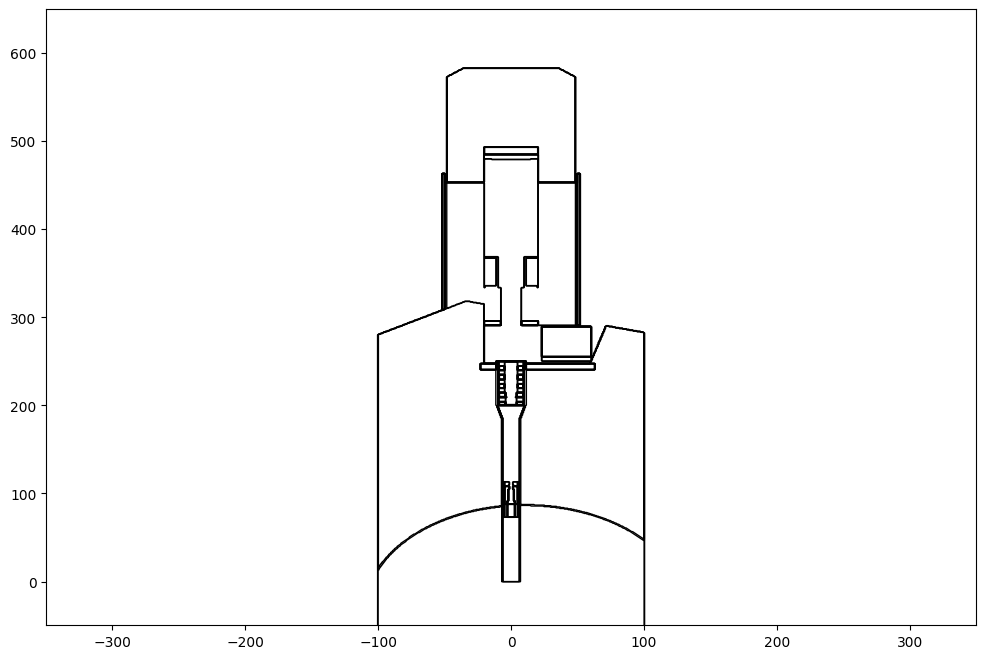

In [66]:
geom=np.array(Image.open('plot_1.ppm').convert('L'))
geom_xmin=-350
geom_xmax=350
#geom_ymin=0
#geom_ymax=H
geom_zmin=-50
geom_zmax=650
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))



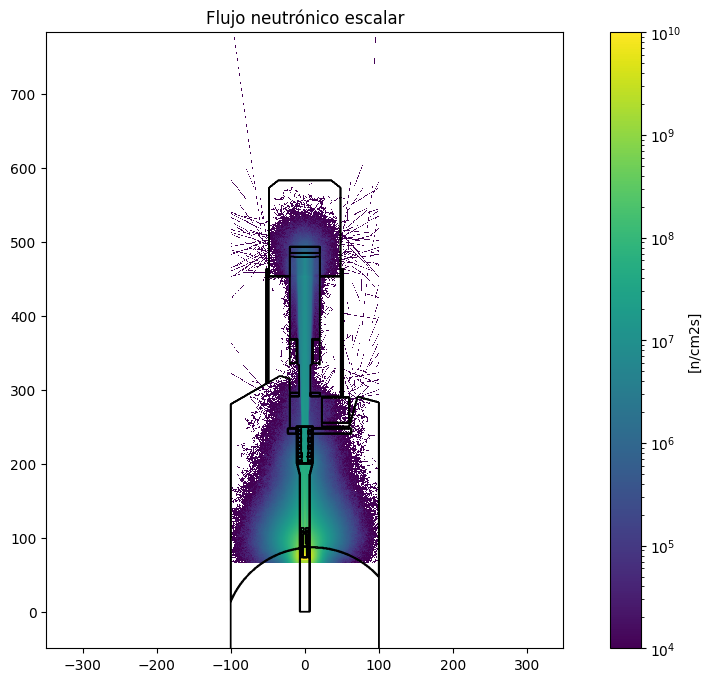

In [67]:
tally=sp.get_tally(name='flux_neutron_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nz,Nx)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nz,Nx)  #idem desviacion standar

data_mean=data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()


plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='viridis',norm=LogNorm(vmin=1e4, vmax=1e10))
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo neutrónico escalar')
plt.savefig("flujo_n.pdf")
plt.show()

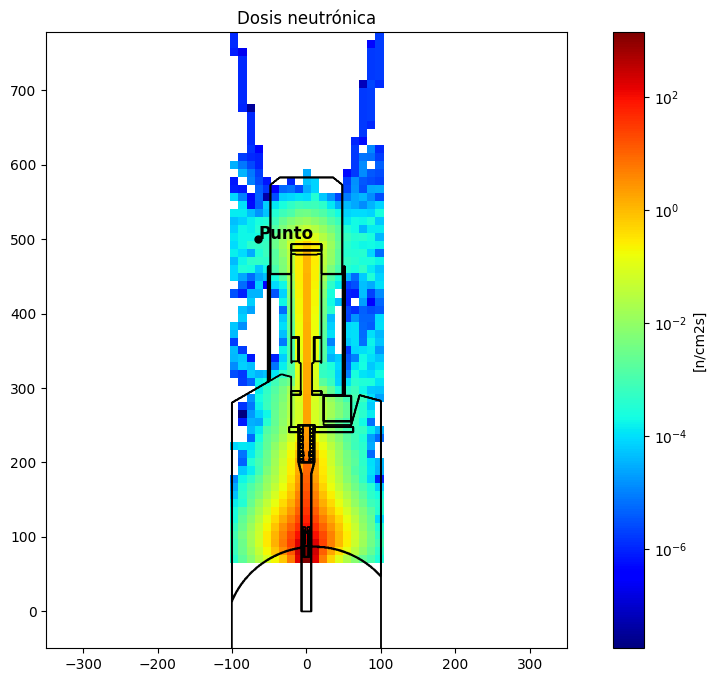

In [118]:
tally=sp.get_tally(name='dose_neutron_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nz,Nx)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nz,Nx)  #idem desviacion standar

data_mean=data.mean*S0*1E-12*3600/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S0*1E-12*3600/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm())
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Dosis neutrónica')

x_punto = -6*(189*2/35)
z_punto = 40*(783-65)/66 +65
plt.plot(x_punto, z_punto, 'ko', markersize=5)  # x y z son las coordenadas del punto
plt.text(x_punto + 0.1, z_punto + 0.1, 'Punto', color='black', fontsize=12, fontweight='bold')

plt.savefig("dosis_n.pdf")
plt.show()



In [108]:
print(data.mean[40][11]*1E6,
data.std_dev[40][11]*1E6)

101.83409810978908 58.44982364833613


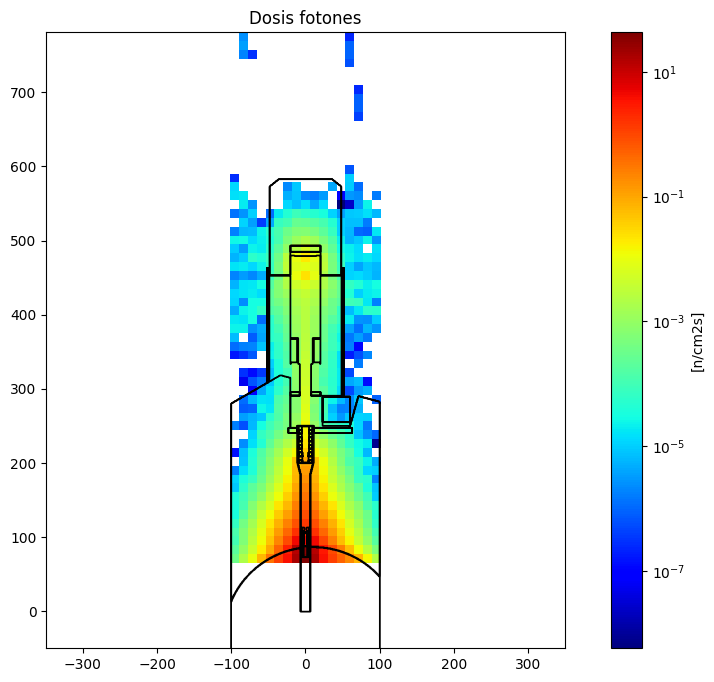

In [111]:
tally=sp.get_tally(name='dose_photon_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nz,Nx)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nz,Nx)  #idem desviacion standar

data_mean=data.mean*S0*1E-12*3600/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S0*1E-12*3600/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm())
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Dosis fotones')
plt.savefig("dosis_p.pdf")
plt.show()

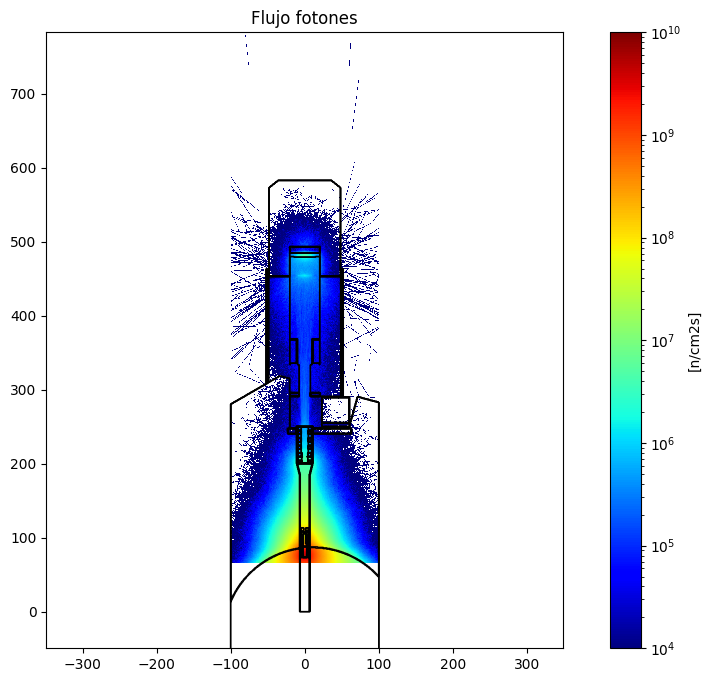

In [113]:
tally=sp.get_tally(name='flux_photon_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nx,Nz)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nx,Nz)  #idem desviacion standar

data_mean=data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm( vmin=1e4, vmax=1e10))
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo fotones')
plt.savefig("flujo_fotones.pdf")
plt.show()

In [71]:
TRAC_b  =   kds.SurfaceSourceFile("surface_source.mcpl")

MCPLError: Unable to open file!

In [72]:
track1 = TRAC_b.get_pandas_dataframe()
trackn_0=TRAC_b.get_pandas_dataframe()
trackn_0=trackn_0[trackn_0['type'] == 2112]
trackp_0=TRAC_b.get_pandas_dataframe()
trackp_0=trackp_0[trackp_0['type'] == 22]

In [73]:
trackn_0['wgt']

1        0.966785
5        0.631123
6        0.617610
7        0.617419
8        0.609205
           ...   
27883    0.999498
27884    0.625908
27886    0.883248
27888    0.994612
27889    0.995847
Name: wgt, Length: 17531, dtype: float64

In [60]:
trackp_0

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
0,0,22.0,1.678362,2.339841,2.772195,113.099998,-0.650261,0.102332,0.752788,0.531980,...,0.0,0.0,3.627661,0.869773,0.752788,0.718509,2.985503,2.477914,-0.274105,0.007387
1,1,22.0,0.477602,-3.314535,1.576652,113.099998,0.370538,0.422010,0.827411,0.502269,...,0.0,0.0,3.670419,2.697591,0.827411,0.596314,0.850252,3.734710,-0.299063,0.025960
3,3,22.0,7.645600,-0.710718,-1.341264,113.099998,0.019172,-0.803225,0.595367,0.539611,...,0.0,0.0,1.517929,-2.058067,0.595367,0.933074,-1.546932,0.961602,-0.267919,0.001622
6,6,22.0,0.477602,-0.763704,-0.321922,113.099998,0.371883,0.669083,0.643453,0.504337,...,0.0,0.0,0.828780,-2.742667,0.643453,0.871796,1.063503,3.734710,-0.297279,0.025960
11,11,22.0,0.847000,4.327073,0.617232,113.099998,0.155317,-0.583407,0.797190,0.500012,...,0.0,0.0,4.370874,0.141688,0.797190,0.648169,-1.310607,3.161787,-0.301019,0.014638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4679,4679,22.0,0.187911,0.455881,-1.840967,113.099998,0.364509,-0.222145,-0.904315,0.501041,...,0.0,0.0,1.896572,-1.328048,-0.904315,2.700568,-0.547329,4.667519,-0.300127,0.065980
4686,4686,22.0,0.253157,-1.047673,-1.927202,113.099998,-0.058844,0.897816,-0.436421,0.570677,...,0.0,0.0,2.193564,-2.068731,-0.436421,2.022414,1.636245,4.369477,-0.243610,0.048975
4687,4687,22.0,1.591492,-2.135324,-1.527443,113.099998,0.494966,0.537890,0.682409,0.526871,...,0.0,0.0,2.625394,-2.520658,0.682409,0.819743,0.826933,2.531060,-0.278296,0.007790
4689,4689,22.0,0.477602,2.104594,1.447187,113.099998,0.485452,-0.526356,0.698059,0.501355,...,0.0,0.0,2.554147,0.602377,0.698059,0.798114,-0.825802,3.734710,-0.299855,0.025960


In [61]:
trackn_0_colimador=trackn_0[trackn_0['z']==113.1]
trackn_0_conducto=trackn_0[trackn_0['z']!=113.1]
trackn_0_conducto

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
2,2,2112.0,0.000749,0.328577,0.299695,113.099998,-0.201675,0.571146,0.795688,0.500436,...,0.0,0.0,0.444725,0.739459,0.795688,0.650653,1.910235,10.192448,-0.300651,0.010450
4,4,2112.0,0.000078,2.885988,-0.493222,113.099998,-0.610498,-0.755894,0.236467,0.500690,...,0.0,0.0,2.927832,-0.169267,0.236467,1.332069,-2.250185,12.455241,-0.300431,0.032396
5,5,2112.0,0.000570,-3.958746,2.455138,113.099998,0.714027,0.503749,-0.486213,0.500808,...,0.0,0.0,4.658259,2.586466,-0.486213,2.078547,0.614411,10.466470,-0.300329,0.011985
7,7,2112.0,0.012198,0.538335,-0.440603,113.099998,0.072281,0.061455,0.995489,0.500282,...,0.0,0.0,0.695654,-0.685893,0.995489,0.095018,0.704630,7.402218,-0.300785,0.002590
8,8,2112.0,0.020540,-3.393945,-2.387178,113.099998,0.838278,0.076600,-0.539836,0.500238,...,0.0,0.0,4.149395,-2.528613,-0.539836,2.141039,0.091125,6.881125,-0.300823,0.001996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,4682,2112.0,0.007180,-1.915289,-4.204107,113.099998,-0.208372,0.519743,0.828522,0.500396,...,0.0,0.0,4.619832,-1.998277,0.828522,0.594334,1.952091,7.932235,-0.300686,0.003375
4683,4683,2112.0,0.005793,1.353606,2.485308,113.099998,0.254370,0.530646,-0.808524,0.500835,...,0.0,0.0,2.830018,1.072075,-0.808524,2.512436,1.123798,8.146767,-0.300305,0.003758
4684,4684,2112.0,0.000005,0.792027,0.580776,113.099998,-0.503791,0.257767,-0.824470,0.505601,...,0.0,0.0,0.982145,0.632713,-0.824470,2.540062,2.668665,15.145485,-0.296192,0.124358
4685,4685,2112.0,1.495710,-0.874484,0.979100,113.099998,-0.229480,-0.494113,0.838565,0.500021,...,0.0,0.0,1.312768,2.299815,0.838565,0.576153,-2.005583,2.593131,-0.301012,0.000234


In [62]:
trackp_0_colimador=trackp_0[trackp_0['z']==113.1]
trackp_0_conducto=trackp_0[trackp_0['z']!=113.1]
trackp_0_colimador

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda


In [63]:
sets = openmc.Settings()
sets.run_mode = "fixed source"
sets.particles = len(track1)
sets.batches = 1
sets.inactive = 0
sets.source = openmc.FileSource(path='surface_source.mcpl')
sets.sourcepoint={'write':False}
#sets.trace=(19,1,72)       #numero de batch, yNP numero de particulo, 1 es el numero de generacion (no hya n de fision)
sets.photon_transport = True
sets.survival_biasing=False   #reduccion de varianzas
sets.output={'tallies':False}   #para no escribir tallies.out que no lo necesito y tarda


In [64]:
# newtrack

In [65]:
tallies=openmc.Tallies()

#130 es ancho de caja en x . Linner-origen de fuente y Louter= donde termina la caja en z
#Linner_flux=0
Linner_flux=65            #comienzo del zafiro
Louter_flux=783             #termina caja 2m luego del beam

#Filtro de grilla
mesh_xz_flux = openmc.RegularMesh(mesh_id=1)
mesh_xz_flux.lower_left=[-200,-9.77/2,Linner_flux]                     #9 es el radio del conducto a la salida
mesh_xz_flux.upper_right=[200,9.77/2,Louter_flux]
mesh_xz_flux.dimension=[1000,1,1000]
filter_mesh_xz_flux = openmc.filter.MeshFilter(mesh_xz_flux,filter_id=1)

Linner_dose_n=65            #comienzo del zafiro
Louter_dose_n=783            #casi 2m luego que termina el beam
#hice un cuadrado aunque el detector es cilindrico
mesh_xz_dose_n = openmc.RegularMesh(mesh_id=2)
mesh_xz_dose_n.lower_left=[-189,-12.5,Linner_dose_n]
mesh_xz_dose_n.upper_right=[189,12.5,Linner_dose_n+66*10.8]
mesh_xz_dose_n.dimension=[int(35),1,66]
filter_mesh_xz_dose_n = openmc.filter.MeshFilter(mesh_xz_dose_n ,filter_id=2)


Linner_dose_p=65           #comienzo del zafiro
Louter_dose_p=775.2             #casi 2m luego que termina el beam
#2.1 es la mitad en y, y el 197 tiene que ver con que para que me quede justo en x no tome 400 si no 300 y pico
mesh_xz_dose_p = openmc.RegularMesh(mesh_id=3)
mesh_xz_dose_p.lower_left=[-196.845,-2.1,Linner_dose_p]
mesh_xz_dose_p.upper_right=[196.845,2.1,Linner_dose_p+60*11.93]
mesh_xz_dose_p.dimension=[33,1,60]
filter_mesh_xz_dose_p = openmc.filter.MeshFilter(mesh_xz_dose_p ,filter_id=3)

# mesh_yz = openmc.RegularMesh(mesh_id=2)
# mesh_yz.lower_left=[-1.45/2,-130,Linner]
# mesh_yz.upper_right=[1.45/2,130,Louter]
# mesh_yz.dimension=[1,1000,1000]
# filter_mesh_yz = openmc.filter.MeshFilter(mesh_yz,filter_id=2)

# mesh_xy = openmc.RegularMesh(mesh_id=3)
# mesh_xy.lower_left=[-15,-15,Louter-290]
# mesh_xy.upper_right=[15,15,Louter-290+5]
# mesh_xy.dimension=[1000,1000,1]
# filter_mesh_xy = openmc.filter.MeshFilter(mesh_xy,filter_id=3)

# mesh_surf = openmc.RegularMesh(mesh_id=4)
# mesh_surf.lower_left=[-1.45/2,-3.1/2,L4int]
# mesh_surf.upper_right=[1.45/2,3.1/2,L6ext]
# mesh_surf.dimension=[1,1,1]
# filter_mesh_surf = openmc.filter.MeshSurfaceFilter(mesh_surf,filter_id=4)

# Filtro de particulas
neutron=openmc.ParticleFilter(['neutron'],filter_id=5)
photon=openmc.ParticleFilter(['photon'],filter_id=6)

# Filtro de dosis
En_ARN,h10n_ARN=np.loadtxt('h10ARN_neutron',unpack=True)
Eg_ARN,h10g_ARN=np.loadtxt('h10ARN_photon',unpack=True)

filter_dose_neutron=openmc.filter.EnergyFunctionFilter(En_ARN,h10n_ARN,filter_id=7)
filter_dose_photon=openmc.filter.EnergyFunctionFilter(Eg_ARN,h10g_ARN,filter_id=8)

#Filtro de energías
# filter_energy_neutron=openmc.filter.EnergyFilter(logspace(log10(1e-5),log10(2e7),201),filter_id=9)
# filter_energy_photon=openmc.filter.EnergyFilter(linspace(0,2e7,201),filter_id=10)


#z_scolimador=113.1
#sur_colimador=openmc.ZPlane(z0=z_scolimador,surface_id=10000, name="plano_csolimador")
# z_fin_conducto=250.3
# sur_conducto=openmc.ZPlane(z0=z_fin_conducto,surface_id=20000, name="plano_conducto")
# Filtro de celdas
filter_surf_colimador=openmc.filter.SurfaceFilter([planoZ_104],filter_id=11)
filter_surf_conducto=openmc.filter.SurfaceFilter([planoZ_6],filter_id=12)
# filter_surf_INICIO=openmc.filter.SurfaceFilter([planoZ_TRACK],filter_id=13)
# filter_cell=openmc.filter.CellFilter([cell5001],filter_id=12)
# filter_detector=openmc.filter.CellFilter([cell8900],filter_id=13)

# Tallies
# dose_neutron_xy = openmc.Tally(name='dose_neutron_xy',tally_id=1)
# dose_neutron_xy.scores = ["flux"]
# dose_neutron_xy.filters = [filter_mesh_xy,filter_dose_neutron,neutron]
# tallies.append(dose_neutron_xy)

# dose_photon_xy = openmc.Tally(name='dose_photon_xy',tally_id=2)
# dose_photon_xy.scores = ["flux"]
# dose_photon_xy.filters = [filter_mesh_xy,filter_dose_photon,photon]
# tallies.append(dose_photon_xy)

# flux_neutron_xy = openmc.Tally(name='flux_neutron_xy',tally_id=3)
# flux_neutron_xy.scores = ["flux"]
# flux_neutron_xy.filters = [filter_mesh_xy,neutron]
# tallies.append(flux_neutron_xy)

# flux_photon_xy = openmc.Tally(name='flux_photon_xy',tally_id=4)
# flux_photon_xy.scores = ["flux"]
# flux_photon_xy.filters = [filter_mesh_xy,photon]
# tallies.append(flux_photon_xy)

dose_neutron_xz = openmc.Tally(name='dose_neutron_xz',tally_id=5)
dose_neutron_xz.scores = ["flux"]
dose_neutron_xz.filters = [filter_mesh_xz_dose_n,filter_dose_neutron,neutron]
tallies.append(dose_neutron_xz)

dose_photon_xz = openmc.Tally(name='dose_photon_xz',tally_id=6)
dose_photon_xz.scores = ["flux"]
dose_photon_xz.filters = [filter_mesh_xz_dose_p,filter_dose_photon,photon]
tallies.append(dose_photon_xz)

flux_neutron_xz = openmc.Tally(name='flux_neutron_xz',tally_id=7)
flux_neutron_xz.scores = ["flux"]
flux_neutron_xz.filters = [filter_mesh_xz_flux,neutron]
tallies.append(flux_neutron_xz)

flux_photon_xz = openmc.Tally(name='flux_photon_xz',tally_id=8)
flux_photon_xz.scores = ["flux"]
flux_photon_xz.filters = [filter_mesh_xz_flux,photon]
tallies.append(flux_photon_xz)

# dose_neutron_yz = openmc.Tally(name='dose_neutron_yz',tally_id=9)
# dose_neutron_yz.scores = ["flux"]
# dose_neutron_yz.filters = [filter_mesh_yz,filter_dose_neutron,neutron]
# tallies.append(dose_neutron_yz)

# dose_photon_yz = openmc.Tally(name='dose_photon_yz',tally_id=10)
# dose_photon_yz.scores = ["flux"]
# dose_photon_yz.filters = [filter_mesh_yz,filter_dose_photon,photon]
# tallies.append(dose_photon_yz)

# flux_neutron_yz = openmc.Tally(name='flux_neutron_yz',tally_id=11)
# flux_neutron_yz.scores = ["flux"]
# flux_neutron_yz.filters = [filter_mesh_yz,neutron]
# tallies.append(flux_neutron_yz)

# flux_photon_yz = openmc.Tally(name='flux_photon_yz',tally_id=12)
# flux_photon_yz.scores = ["flux"]
# flux_photon_yz.filters = [filter_mesh_yz,photon]
# tallies.append(flux_photon_yz)

# spectra_neutron = openmc.Tally(name='spectra_neutron',tally_id=13)
# spectra_neutron.scores = ['current']
# spectra_neutron.filters = [filter_energy_neutron,filter_mesh_surf,neutron]
# tallies.append(spectra_neutron)

# spectra_photon = openmc.Tally(name='spectra_photon',tally_id=14)
# spectra_photon.scores = ['current']
# spectra_photon.filters = [filter_energy_photon,filter_mesh_surf,photon]
# tallies.append(spectra_photon)

# patron_neutron=openmc.Tally(name='patron_neutron',tally_id=15)
# patron_neutron.scores=['flux']
# patron_neutron.filters=[filter_energy_neutron,filter_cell,neutron]
# tallies.append(patron_neutron)

# patron_photon=openmc.Tally(name='patron_photon',tally_id=16)
# patron_photon.scores=['flux']
# patron_photon.filters=[filter_energy_photon,filter_cell,photon]
# tallies.append(patron_photon)

# track_neutron_colimador=openmc.Tally(name='track_neutron',tally_id=19)
# track_neutron_colimador.scores=['track-surface']
# track_neutron_colimador.filters=[filter_surf_colimador,neutron]
# tallies.append(track_neutron_colimador)

# track_photon_colimador=openmc.Tally(name='track_photon',tally_id=20)
# track_photon_colimador.scores=['track-surface']
# track_photon_colimador.filters=[filter_surf_colimador,photon]
# tallies.append(track_photon_colimador)

# track_neutron_conducto=openmc.Tally(name='track_neutron',tally_id=21)
# track_neutron_conducto.scores=['track-surface']
# track_neutron_conducto.filters=[filter_surf_conducto,neutron]
# tallies.append(track_neutron_conducto)

# track_photon_conducto=openmc.Tally(name='track_photon',tally_id=22)
# track_photon_conducto.scores=['track-surface']
# track_photon_conducto.filters=[filter_surf_conducto,photon]
# tallies.append(track_photon_conducto)


# track_neutron_INICIO=openmc.Tally(name='track_neutron',tally_id=23)
# track_neutron_INICIO.scores=['track-surface']
# track_neutron_INICIO.filters=[filter_surf_INICIO,neutron]
# tallies.append(track_neutron_INICIO)

# track_photon_INICIO=openmc.Tally(name='track_photon',tally_id=24)
# track_photon_INICIO.scores=['track-surface']
# track_photon_INICIO.filters=[filter_surf_INICIO,photon]
# tallies.append(track_photon_INICIO)



# detector_neutron=openmc.Tally(name='detector_neutron',tally_id=21)
# detector_neutron.scores=['flux']
# detector_neutron.filters=[filter_energy_neutron,filter_detector,neutron]
# tallies.append(detector_neutron)

# detector_photon=openmc.Tally(name='detector_photon',tally_id=22)
# detector_photon.scores=['flux']
# detector_photon.filters=[filter_energy_photon,filter_detector,photon]
# tallies.append(detector_photon)

tallies.export_to_xml()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=3.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70

In [66]:
!rm *.xml
#plots.export_to_xml()


# openmc_exec = '/home/zoe/openmc/build-surftrack/bin/openmc' # esto es por si tengo muchas versiones instaladas
# openmc_data = "/home/zoe/openmc-data/endfb71_hdf5/cross_sections_sapphire.xml"

geom = openmc.Geometry(univ01) #solo 1 universo
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values()) # con este comando, me aseguro de exportar solo los materiales que aparecen en la geometría
mats.cross_sections = openmc_data
mats.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

#celda generica -> siempre se usa

In [ ]:
!rm summary.h5 #por corridas anteriores
!rm statepoint.1.h5
!rm surftrack.txt
# openmc.run(openmc_exec=openmc_exec, geometry_debug=False)
openmc.run(geometry_debug=False)

rm: cannot remove 'summary.h5': No such file or directory
rm: cannot remove 'statepoint.1.h5': No such file or directory
rm: cannot remove 'surftrack.txt': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%

In [ ]:
!mv statepoint.1.h5 statepoint_KDE.h5    #el 10 es el numero de batches
!mv surftrack.txt surftrack_1.txt

mv: cannot stat 'surftrack.txt': No such file or directory


In [ ]:
sp_1=openmc.StatePoint('statepoint_KDE.h5')

In [ ]:
S0=1

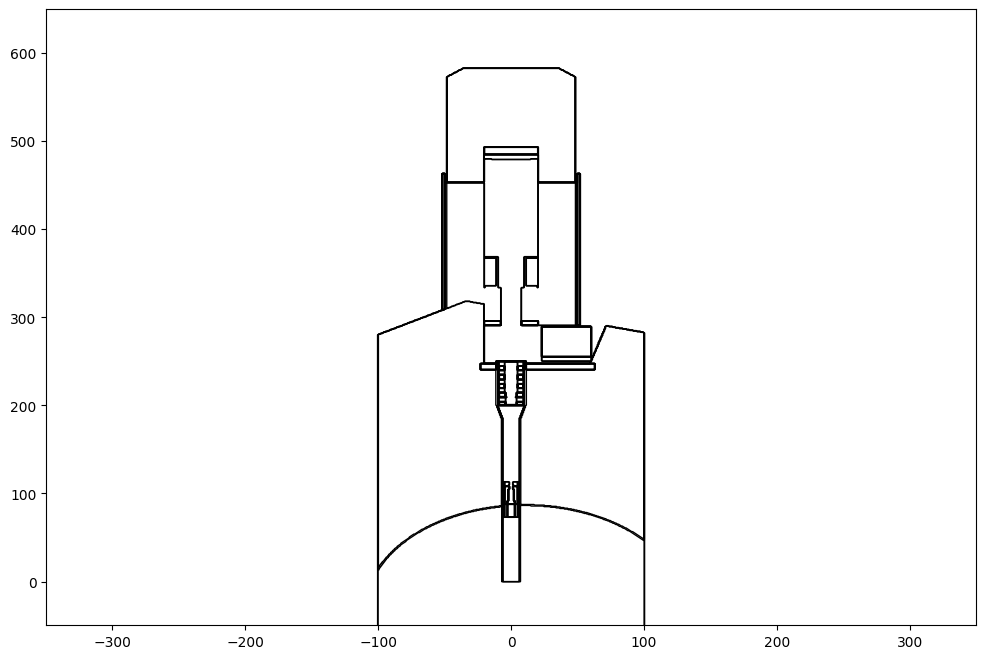

In [ ]:
geom=np.array(Image.open('plot_1.ppm').convert('L'))
geom_xmin=-350
geom_xmax=350
#geom_ymin=0
#geom_ymax=H
geom_zmin=-50
geom_zmax=650
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))



In [ ]:
track_0=pd.DataFrame(loadtxt('surftrack_0.txt'),columns=['type','ekin','x','y','z','u','v','w','time','weight'])
track_0=track_0[track_0['z']!=113.1]
track_0=track_0[track_0['z']!=250.3]
track_0

FileNotFoundError: surftrack_0.txt not found.

In [ ]:
track_1=pd.DataFrame(loadtxt('surftrack_1.txt'),columns=['type','ekin','x','y','z','u','v','w','time','weight'])
track_1_conducto=track_1[track_1['z']==250.3]
track_1_colimador=track_1[track_1['z']==113.1]
track_1

,type,ekin,x,y,z,u,v,w,time,weight
0,22.0,245415.0,-0.947673,-0.102081,113.1,0.005874,0.016123,0.999853,0.0,0.69425
1,22.0,245415.0,-0.947673,-0.102081,113.1,0.005874,0.016123,0.999853,0.0,0.69425
2,22.0,245415.0,-0.947673,-0.102081,113.1,0.005874,0.016123,0.999853,0.0,0.69425
3,22.0,245415.0,-0.141597,2.110330,250.3,0.005874,0.016123,0.999853,0.0,0.69425
4,22.0,245415.0,-0.141597,2.110330,250.3,0.005874,0.016123,0.999853,0.0,0.69425
...,...,...,...,...,...,...,...,...,...,...
57821,22.0,1232430.0,-3.405740,1.777760,113.1,-0.542023,0.195844,0.817225,0.0,0.99752
57822,22.0,1232430.0,-3.405740,1.777760,113.1,-0.542023,0.195844,0.817225,0.0,0.99752
57823,22.0,1232430.0,-3.405740,1.777760,113.1,-0.542023,0.195844,0.817225,0.0,0.99752
57824,22.0,875966.0,2.913440,-4.115540,250.3,-0.008046,-0.003946,0.999960,0.0,0.94688


In [ ]:
trackn_1_conducto=track_1_conducto[track_1_conducto['type']==2112]
trackn_1_colimador=track_1_colimador[track_1_colimador['type']==2112]
trackn_1_conducto

,type,ekin,x,y,z,u,v,w,time,weight
119,2112.0,0.012668,1.130360,3.337030,250.3,0.009579,0.029204,0.999528,0.0,0.873524
120,2112.0,0.012668,1.130360,3.337030,250.3,0.009579,0.029204,0.999528,0.0,0.873524
144,2112.0,0.057386,-0.034690,-2.555180,250.3,-0.000282,-0.027928,0.999610,0.0,0.254815
145,2112.0,0.057386,-0.034690,-2.555180,250.3,-0.000282,-0.027928,0.999610,0.0,0.254815
453,2112.0,0.009091,-1.423670,1.448910,250.3,-0.012999,0.007228,0.999889,0.0,0.267606
...,...,...,...,...,...,...,...,...,...,...
47783,2112.0,0.112851,-0.556869,-0.048745,250.3,-0.011954,-0.003244,0.999923,0.0,0.525307
47826,2112.0,0.041902,3.027680,2.749960,250.3,0.025063,0.019405,0.999498,0.0,0.711181
47827,2112.0,0.041902,3.027680,2.749960,250.3,0.025063,0.019405,0.999498,0.0,0.711181
47864,2112.0,0.070362,-0.804629,-2.563050,250.3,0.003770,-0.014530,0.999887,0.0,0.255888


In [ ]:
trackp_1_conducto=track_1_conducto[track_1_conducto['type']==22]
trackp_1_colimador=track_1_colimador[track_1_colimador['type']==22]
trackp_1_conducto

,type,ekin,x,y,z,u,v,w,time,weight
3,22.0,245415.0,-0.141597,2.11033,250.3,0.005874,0.016123,0.999853,0.0,0.69425
4,22.0,245415.0,-0.141597,2.11033,250.3,0.005874,0.016123,0.999853,0.0,0.69425
20,22.0,3517200.0,-0.228234,2.50819,250.3,-0.009012,-0.019809,0.999763,0.0,0.97836
21,22.0,3517200.0,-0.228234,2.50819,250.3,-0.009012,-0.019809,0.999763,0.0,0.97836
43,22.0,2580840.0,1.081530,-1.15179,250.3,0.004429,-0.003861,0.999983,0.0,0.99638
...,...,...,...,...,...,...,...,...,...,...
57743,22.0,4983290.0,4.317090,-2.07475,250.3,0.034819,-0.008025,0.999361,0.0,0.97416
57795,22.0,1459490.0,-3.384040,4.28820,250.3,0.009455,0.018011,0.999793,0.0,0.99997
57796,22.0,1459490.0,-3.384040,4.28820,250.3,0.009455,0.018011,0.999793,0.0,0.99997
57824,22.0,875966.0,2.913440,-4.11554,250.3,-0.008046,-0.003946,0.999960,0.0,0.94688


In [ ]:
#S1=S0*sum(track_0[track_0['type']==2112]['weight']/len(track_0))/sum(track_1[track_1['type']==2112]['weight']/(len(track_1)))
S1=S0*sum(track_0[track_0['type']==2112]['weight']/(sp.n_batches*sp.n_particles))/sum(track_1[track_1['type']==2112]['weight']/(sp_1.n_batches*sp_1.n_particles))
print(S0)
print(S1)


1
0.20252488699876156


In [ ]:
print(S0*sum(track_0[track_0['type']==2112]['weight'])/(sp.n_batches*sp.n_particles))
print(S1*sum(track_1[track_1['type']==2112]['weight'])/(sp_1.n_batches*sp_1.n_particles))

0.004018134893632815
0.004018134893632815


In [ ]:
#codigo para poder printear, despues lo arreglo
S1 = 1

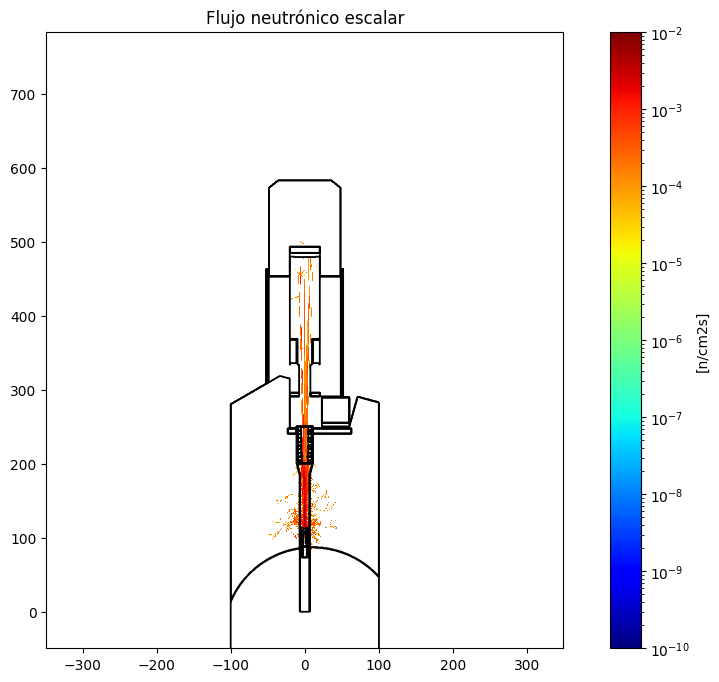

In [ ]:
tally_1=sp_1.get_tally(name='flux_neutron_xz')
mesh_filter_1=tally_1.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data_1=tally_1.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx_1=mesh_filter_1.mesh.dimension[0]   #en cuanto dividi
xmin_1=mesh_filter_1.mesh.lower_left[0]  #punta del mesh
xmax_1=mesh_filter_1.mesh.upper_right[0] #la otra punta
dx_1=xmax_1-xmin_1   # ancho en x

Ny_1=mesh_filter_1.mesh.dimension[1]
ymin_1=mesh_filter_1.mesh.lower_left[1]
ymax_1=mesh_filter_1.mesh.upper_right[1]
dy_1=ymax_1-ymin_1

Nz_1=mesh_filter_1.mesh.dimension[2]
zmin_1=mesh_filter_1.mesh.lower_left[2]
zmax_1=mesh_filter_1.mesh.upper_right[2]
dz_1=zmax_1-zmin_1

data_1.mean.shape=(Nz_1,Nx_1)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data_1.std_dev.shape=(Nz_1,Nx_1)  #idem desviacion standar

data_mean_1=data_1.mean*S1/(dx_1/Nx_1*dy_1/Ny_1*dz_1/Nz_1)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv_1=data_1.std_dev*S1/(dx_1/Nx_1*dy_1/Ny_1*dz_1/Nz_1)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean_1,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm(vmin=1e-10, vmax=1e-2))
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo neutrónico escalar')
plt.savefig("flujo_n_KDE.pdf")
plt.show()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


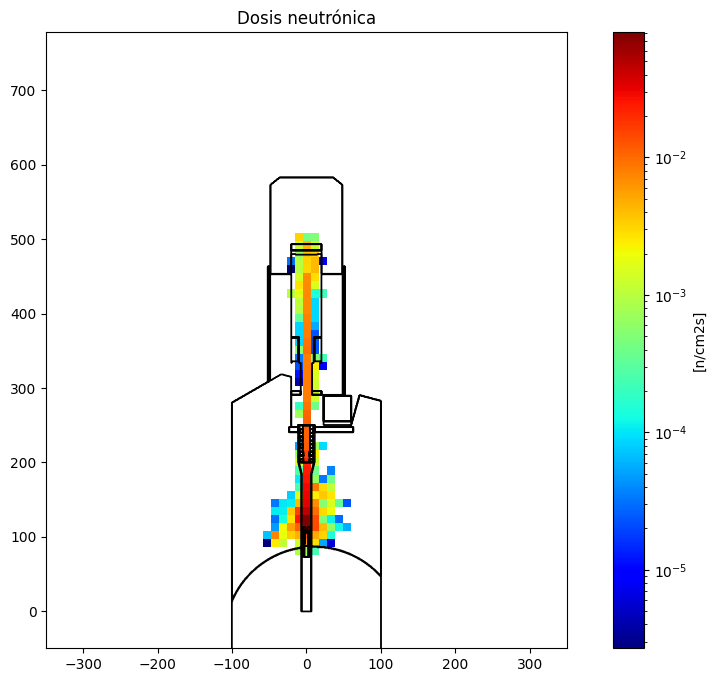

In [ ]:
tally=sp_1.get_tally(name='dose_neutron_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nz,Nx)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nz,Nx)  #idem desviacion standar

data_mean=data.mean*S1/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S1/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm())
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Dosis neutrónica')
plt.savefig("dosis_n_KDE.pdf")
plt.show()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


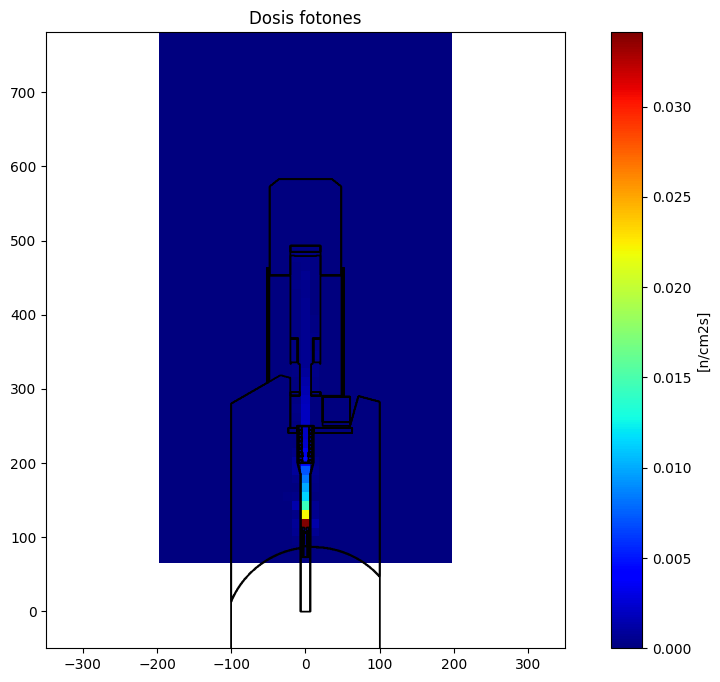

In [ ]:
tally=sp_1.get_tally(name='dose_photon_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nz,Nx)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nz,Nx)  #idem desviacion standar

data_mean=data.mean*S1/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S1/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet')
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Dosis fotones')
plt.savefig("dosis_p_KDE.pdf")
plt.show()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


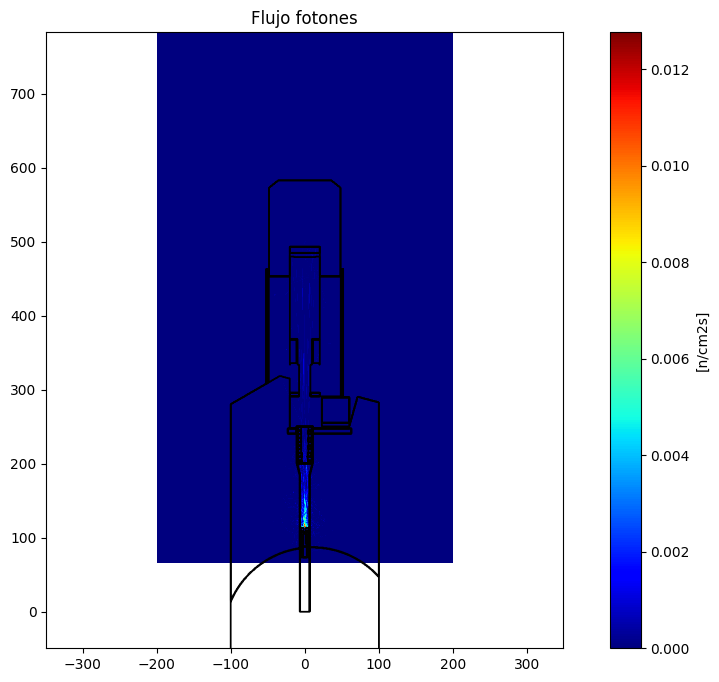

In [ ]:
tally=sp_1.get_tally(name='flux_photon_xz')
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)   #busca filtro de grilla
data=tally.get_slice(scores=['flux']) #devuelve en forma de grilla valor medio y desv standar

Nx=mesh_filter.mesh.dimension[0]   #en cuanto dividi
xmin=mesh_filter.mesh.lower_left[0]  #punta del mesh
xmax=mesh_filter.mesh.upper_right[0] #la otra punta
dx=xmax-xmin   # ancho en x

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nx,Nz)     #promedio asignarle una nueva dimen, grilla de dim 2-> matriz 100x100
data.std_dev.shape=(Nx,Nz)  #idem desviacion standar

data_mean=data.mean*S1/(dx/Nx*dy/Ny*dz/Nz)  #cambio de variables. multiplico por S0 y divido por Vol del diferencial
data_stdv=data.std_dev*S1/(dx/Nx*dy/Ny*dz/Nz)

#plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='jet')
#plt.colorbar()
#plt.show()

plt.rcParams['figure.figsize']=(12,8)
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet')
plt.colorbar(label='[n/cm2s]')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo fotones')
plt.savefig("flujo_fotones.pdf")
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 4)

/tmp/ipykernel_10074/2507288425.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(data_mean/data_mean_1,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet', vmin=0.5, vmax=1.5)
/tmp/ipykernel_10074/2507288425.py:21: RuntimeWarning: invalid value encountered in divide
  plt.imshow(data_mean/data_mean_1,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet', vmin=0.5, vmax=1.5)


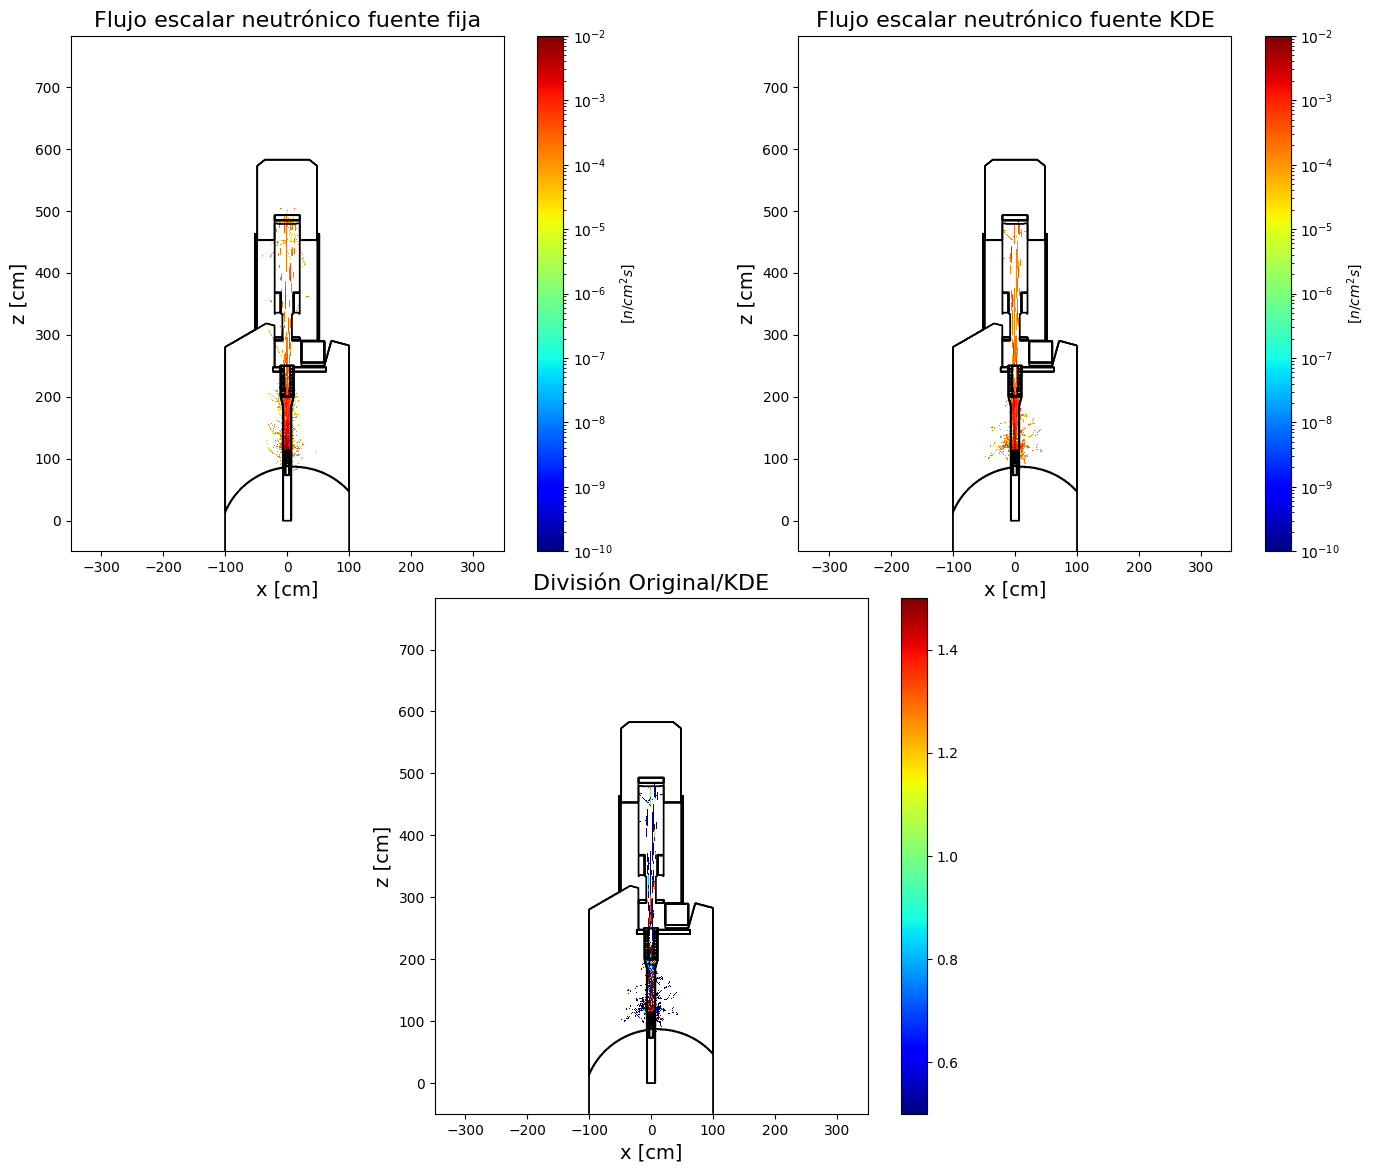

In [ ]:
fig= plt.figure(figsize=(18,14))

plt.subplot(gs[:2, :2])
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet',norm=LogNorm( vmin=1e-10, vmax=1e-2))
plt.colorbar(label='[$n/cm^{2}s]$')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo escalar neutrónico fuente fija', size=16)
plt.xlabel('x [cm]', size=14)
plt.ylabel('z [cm]',size=14)


plt.subplot(gs[:2, 2:])
plt.imshow(data_mean_1,origin='lower',interpolation='none',extent=(xmin_1,xmax_1,zmin_1,zmax_1),cmap='jet',norm=LogNorm(vmin=1e-10, vmax=1e-2))
plt.colorbar(label='[$n/cm^{2}s]$')
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('Flujo escalar neutrónico fuente KDE', size=16)
plt.xlabel('x [cm]', size=14)
plt.ylabel('z [cm]',size=14)

plt.subplot(gs[2:4, 1:3])
plt.imshow(data_mean/data_mean_1,origin='lower',interpolation='none',extent=(xmin,xmax,zmin,zmax),cmap='jet', vmin=0.5, vmax=1.5)
plt.colorbar()
plt.contour(geom, levels=10,colors='black',origin='image',linewidths=1,extent=(geom_xmin,geom_xmax,geom_zmin,geom_zmax))
plt.title('División Original/KDE',size=16)
plt.xlabel('x [cm]', size=14)
plt.ylabel('z [cm]',size=14)
plt.savefig("flujo_KDE.pdf")
plt.show()